# Generates artificial VSD videos

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.decomposition import FastICA, PCA
np.set_printoptions(precision=2)

# Global parameters

In [2]:
Desired_SNR_dB = 4.4     # Desired Signal-to-Noise Ratio (SNR) per Region of Interest (ROI) in decibels (dB)
Desired_SNR_SD_dB = 3.2   # Desired variation of SNR among ROIs (only used if SNR_distribution = 'normal')
Desired_Max_SNR_dB = 8.4   # Desired Max ROI SNR (only used if SNR_distribution = 'follow_BF')
Desired_Min_SNR_dB = -4.5 # Desired Min ROI SNR (only used if SNR_distribution = 'follow_BF')
SNR_distribution = 'BF_modulated' # Way to distribute SNR in ROIs: 
                             #                               - 'uniform': all ROIs will have the same SNR
                             #                               - 'normal': SNR will be defined by a normal distribution
                             #                                             with mean = Desired_SNR_dB 
                             #                                             and std = Desired_SNR_SD_dB
                             #                               - 'BF_modulated': SNR will be spatially modulated based on 
                             #                                                  Basal Fluorescence, linearly distributed 
                             #                                                  from Min to Max levels
video_duration = 5      # (in seconds)
fs = 67.8               # sampling frequency (in Hz); max = 10kHz
photobleaching_drift_percent = 0.3 #(%)
# Signal/Noise Switches
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = True
Poisson_noise_switch = True

# Photobleaching behavior, noise characteristics and basal fluorescence levels based on Cell1 experimental data (video0).
# Cell mask based on Cell2 experimental data (to avoid confusion with Cell1 experimental data results)

# Video equation

### Briefly, the following equation shows how the artificial video is built:

#### Artificial Fluorescene Video Equation:

$$F(x,y,t) = BF_{Switch}*BF(x,y) + Signal_{Switch}*EP^{*}(x,y,BF,g,t) +\ $$ 
$$Photobleaching_{Switch}*Photobleaching(BF,t) + Noise_{Switch}*Noise(x,y,t)$$

__Switch type variables are binary variables that determine which components will be added to the video__

_______________________________________________________________________________
### Below we show how each video component is obtained:

$experimental\_vid(x,y,t)$ : Experimental video (Cell1, video0)
_______________________________________________________________________________
### Basal Fluorescence (BF(x,y)) Calculation:

$$first\_img(x,y) = experimental\_vid(x,y,t=0)$$

$$K_{illum}(x,y) = G_{\sigma=\frac{min(first\_img\_height,first\_img\_width)}{2}}\bigotimes first\_img(x,y)$$

$$\hat{K_{illum}}(x,y) = \frac{K_{illum}(x,y)}{max[K_{illum}(x,y)]}$$

$\overline{\overline{F_{BG}}}$ : experimental video background grand mean

$\overline{\overline{F_{CELL}}}$ : experimental video cell grand mean

$$BF(x,y,\overline{\overline{F_{BG}}},\overline{\overline{F_{CELL}}},W1,\hat{K_{illum}}) = \left\{\begin{matrix}
G_{\sigma=2}\bigotimes \left [ W1*\overline{\overline{F_{BG}}}*\hat{K_{illum}}(x,y) \right ], & \left ( x,y \right ) \in BG\\ 
G_{\sigma=2}\bigotimes \left [ W1*\overline{\overline{F_{CELL}}}*\hat{K_{illum}}(x,y) \right ], & \left ( x,y \right ) \in CELL
\end{matrix}\right.$$

_______________________________________________________________________________
### Poisson Noise (Noise(x,y,t)) Calculation:

#### Correct Non-homogeneous Illumination of Experimental Video (so that variability due to non-homogeneous illumination is excluded from analysis)

$$\hat{K_{illum\_inv}}(x,y) = \frac{\left ( \hat{K_{illum}}(x,y) - min\left ( \hat{K_{illum}}(x,y) \right ) \right )}{1 - min\left ( \hat{K_{illum}}(x,y) \right )}$$

$$experimental\_vid\_Illum\_Corrected(x,y,t) = experimental\_vid(x,y,t)*\hat{K_{illum\_inv}}(x,y)$$

##### spatial background fluorescence variability over time:
 
$$s_{BG\_IC}(t) = \sigma_{experimental\_vid\_Illum\_Corrected(x,y,t)}, \left ( x,y \right ) \in BG$$

##### spatial cell fluorescence variability over time:

$$s_{CELL\_IC}(t) = \sigma_{experimental\_vid\_Illum\_Corrected(x,y,t)}, \left ( x,y \right ) \in CELL$$

#####  temporal mean of $s_{BG\_IC}(t)$ :

$$\overline{s_{BG\_IC}}$$

##### temporal mean of $s_{CELL\_IC}(t)$ :

$$\overline{s_{CELL\_IC}}$$

#####  temporal variability of $s_{BG\_IC}(t)$ :

$$s_{s_{BG\_IC}} = \sigma_{s_{BG\_IC}(t)}$$

##### temporal variability of $s_{CELL\_IC}(t)$ :

$$s_{s_{CELL\_IC}} = \sigma_{s_{CELL\_IC}(t)}$$

##### Variation matrix: matrix whose coordinates determine each pixel variability in noise image

$$std\_matrix(x,y) = \left\{\begin{matrix}
(x,y)\sim N\left (\mu =\overline{s_{CELL\_IC}}, \sigma =s_{s_{CELL\_IC}} \right ), & \left (x,y  \right )\in CELL\\ 
(x,y)\sim N\left (\mu =\overline{s_{BG\_IC}}, \sigma =s_{s_{BG\_IC}} \right ), & \left (x,y  \right )\in BG
\end{matrix}\right.$$

$$var\_matrix(x,y) = std\_matrix^{2}(x,y)$$

$$Noise(x,y,t) = \left [(t) \sim Poisson\left ( \lambda =var\_matrix\left ( x,y \right ) \right )  \right ] - var\_matrix\left ( x,y \right )$$

_______________________________________________________________________________
### Electroporation (EP*(x,y,t)) Signal Calculation:

$(x_{c},y_{c})$ : coordinates of cell centroid

$$\Theta (x,y) = arctan\left ( \frac{y-y_{c}}{x-x_{c}} \right ) - \frac{\pi}{2}$$

$R_{1}$ : radius of cell major axis (aligned to the elctrical field)

$R_{2}$ : radius of cell minor axis (perpendicular to the elctrical field)

$E$ : Electrical field amplitude

$V_{rest}$ : Rest membrane potential

$$\varepsilon = R_{1}^{2} - R_{2}^{2}$$  

$$\Delta V_{m\_stationary}\left ( x,y \right ) = E*\left [ \frac{\varepsilon }{R_{1} - \frac{R_{2}^{2}}{\sqrt{\varepsilon}}ln\left ( \frac{R_{1}+\sqrt{\varepsilon }}{R_{2}} \right )} \right ]*\left [ \frac{R_{2}cos\left ( \Theta \left ( x,y \right ) \right )}{\sqrt{R_{1}^{2}sin^{2}\left ( \Theta \left ( x,y \right ) \right ) + R_{2}^{2}cos^{2}\left ( \Theta \left ( x,y \right ) \right )}} \right ]$$

$$Exp_{50ms}(x,y,t) = \left\{\begin{matrix}
exp\left ( ln\left ( \frac{0.001}{\left | \Delta V_{m\_stationary}\left ( x,y \right ) \right |} \right ) \frac{t}{0.05} \right ), & \Delta V_{m\_stationary}\left ( x,y \right )\neq 0\\ 
0, & \Delta V_{m\_stationary}\left ( x,y \right )=0
\end{matrix}\right.$$

$$\Delta V_{m}\left ( x,y,t \right ) = \left\{\begin{matrix}
\Delta V_{m\_stationary}\left ( x,y \right )*Exp_{50ms}(x,y,t-2.5)*\left [ u\left ( t-2.5 \right ) + V_{rest} \right ] - V_{rest}, & \left ( x,y \right ) \in CELL\\ 
0, & \left ( x,y \right ) \in BG
\end{matrix}\right.$$

$$\hat{\Delta V_{m}}\left ( x,y,t \right ) = \frac{-\left (\Delta V_{m}\left ( x,y,t \right ) + V_{rest} \right )}{max\left [\Delta V_{m}\left ( x,y,t \right ) + V_{rest}\right ]}$$

$$EP\left ( x,y,t \right ) = \left\{\begin{matrix}
BF(x,y,\overline{\overline{F_{BG}}},\overline{\overline{F_{CELL}}},W1,\hat{K_{illum}})*\hat{\Delta V_{m}}\left ( x,y,t \right ), & \left ( x,y \right )\in CELL\\ 
0, & \left ( x,y \right )\in BG
\end{matrix}\right.$$

### Pixel Gain Necessary to achieve Desired ROI SNR (g(x,y)):

##### Let j be the ROI number, $n_{ROIs}$ be the total number of ROIs, and ROI_coords(j) be the image coordinates that belong to ROI(j):

$$ROI\_number = \left \{ j\mid j\in \mathit{N}, and \ 1\leq j\leq n_{ROIs} \right \}$$

$$ROI\_coords(j) = \left \{ (x,y) \mid (x,y) \in \mathit{N}, and \ (x,y) )\in ROI(j) \right \}$$

##### Then:

$$n_{px\_in\_ROI}(j) = card(ROI\_coords(j))$$

##### And by considering noise approximatey white , based on signal averaging, we can calculate each pixel signal gain necessary to achieve a Desired ROI SNR 
##### From signal averaging theory, by considering noise approximately white ($\lambda$ >> 100) and uncorrelated:

$$SNR_{avg,identical\ signals} = n*SNR_{individual\ signals}$$

$$SNR_{avg,identical\ signals} = n*\frac{P}{N}$$

##### A ROI signal is the spatial average of its pixels:

$$SNR_{ROI}(j) = n_{px\_in\_ROI}(j)*\frac{P_{px\_signal}(x,y)}{P_{px\_noise}(x,y)}$$

$$SNR_{ROI}(j) = n_{px\_in\_ROI}(j)*\frac{\sum_{i=1}^{n_{samples}}\left (\left |signal(x,y,i)  \right |  \right )^{2}}{\sum_{i=1}^{n_{samples}}\left (\left |noise(x,y,i)  \right |  \right )^{2}}$$

##### Then we can apply a gain to each pixel g(x,y) in order to reach a desired ROI SNR: 

$$DesiredSNR_{ROI}(j) = n_{px\_in\_ROI}(j)*\frac{\sum_{i=1}^{n_{samples}}\left (\left |g(x,y)*signal(x,y,i)  \right |  \right )^{2}}{\sum_{i=1}^{n_{samples}}\left (\left |noise(x,y,i)  \right |  \right )^{2}}$$

##### For a pure signal video, all pixels have the same signal (with possibly different amplitudes), whereas for a pure noise video, each pixel has an independent noise (by design), therefore:

$$DesiredSNR_{ROI}(j) = g^{2}(x,y)*n_{px\_in\_ROI}(j)*\frac{\sum_{i=1}^{n_{samples}}\left (\left |signal(x,y,i)  \right |  \right )^{2}}{\sum_{i=1}^{n_{samples}}\left (\left |noise(x,y,i)  \right |  \right )^{2}}$$

$$DesiredSNR_{ROI}(j) = g^{2}(x,y)*n_{px\_in\_ROI}(j)*\frac{P_{px\_EP}(x,y)}{P_{px\_Noise}(x,y)}$$

##### Since negative gain is inconsistent, we have:

$$g\left ( x,y \right ) = \left\{\begin{matrix}
\sqrt{\frac{DesiredSNR_{ROI}\left ( j \right )*P_{px\_Noise}\left ( x,y  \right )}{n_{px\_in\_ROI}\left ( j \right )*P_{px\_EP}\left ( x,y \right )}}, &  \left ( x,y \right ) \in ROI\_coords(j)\\ 
1, & \left ( x,y \right ) \notin ROI\_coords(j)
\end{matrix}\right.$$

#### Apply gain to EP signal:

$$EP^{*}(x,y,t) = g\left ( x,y \right )*EP\left ( x,y,t \right )$$

_______________________________________________________________________________
### Photobleaching (Photobleaching(x,y,t)) Calculation:

#### Best fit equation for experimental video mean fluorescence over time: 

$$Best\_fit\_Exp(t) = a\mathit{e}^{-bt}+f\mathit{e}^{-gt}+d$$

##### Normalized Basal Fluorescence:

$$\hat{BF}(x,y) = \frac{BF(x,y)}{max(BF(x,y))}$$

##### Photobleaching modulated by BF

$$Default\_Photobleaching(x,y,t) = \hat{BF}(x,y)*Best\_fit\_Exp(t)$$

##### Shift photobleaching to make it end with amplitude zero and weight it to make first frame mean equals back experimental video:

$$Photobleaching(x,y,t) = W2*(Default\_Photobleaching(x,y,t) - \overline{Default\_Photobleaching(x,y,t=5)})$$



## Build time vectors

In [3]:
n_samples = int((fs*video_duration) + 1) #number of samples
time_sub = np.linspace(0, 5, n_samples) #time vector
# fs = 1/time_sub[1] #sampling frequency

## Create Electroporation (EP) signal (Cathode side example)

In [4]:
time_original = np.arange(0, 5, 0.0001)


#Prolate spheroid model
R1 = 82 #um
R1 /= 1000000  #um to m
R2 = 14.5 #um
R2 /= 1000000  #um to m
E = 32 #V/cm  (applied electric field)
E *= 100  #V/m
tau = 1 #us
tau /= 1000000 #us to s
teta = 0
R2diff = (R1**2) - (R2**2)
Delta_Vm_max = E * ((R2diff)/(R1 - ((R2**2)/np.sqrt(R2diff))*np.log((R1 + np.sqrt(R2diff))/R2))) #* ((R2*np.cos(teta))/np.sqrt(((R1**2)*(np.sin(teta)**2)) + ((R2**2)*(np.cos(teta)**2)))

Delta_Vm_max_t = Delta_Vm_max*np.exp(np.log(0.001/Delta_Vm_max)*(time_original/0.05))

i2_5 = np.argwhere(np.floor(time_original-1.5).clip(min=0))[0][0] #index of time vector where t=2.5sec
EP_original = np.roll(Delta_Vm_max_t,i2_5) 
EP_original[:i2_5] -= 0.08
EP_original *= 1000 #V to mV

Text(0, 0.5, 'Membrane Potential (mV)')

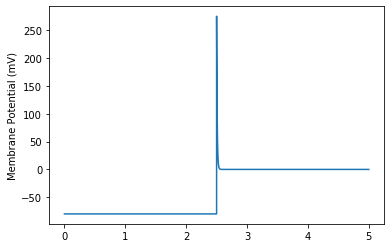

In [5]:
plt.plot(time_original,EP_original)
plt.ylabel('Membrane Potential (mV)')

## Sample EP signal to match samplint frequency (fs)

In [6]:
signal = EP_original+abs(EP_original[0])                          #shift amp from ~-80 to 0
signal = -signal/np.amax(signal)                          #normalize amplitude

yinterp2 = np.interp(time_sub, time_original, EP_original)   #interpolate (subsample) data to experimental video sampling frequency   
i2_5_sub = np.argwhere(np.floor(time_sub-1.5).clip(min=0))[0][0] #index of time vector where t=2.5sec

signal_sub = yinterp2+abs(yinterp2[0])                          #shift amp from ~-80 to 0
signal_sub = -signal_sub/np.amax(signal_sub)                          #normalize amplitude
max_idx_sub = np.argmax(abs(signal_sub))              #index of maximal absolute amplitude


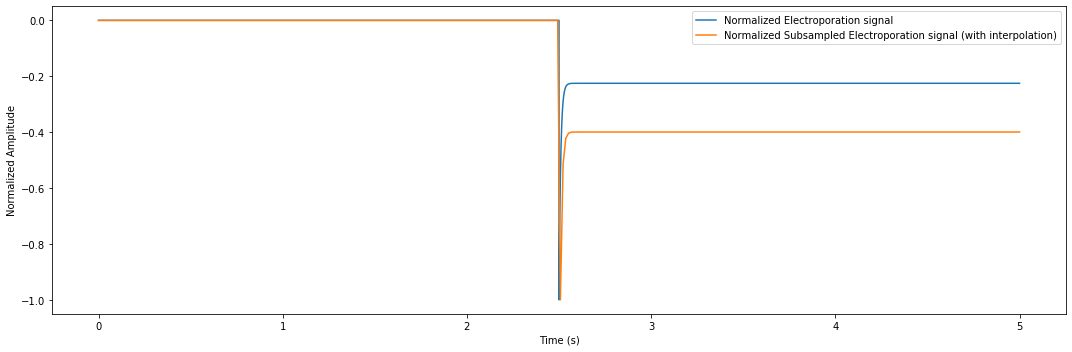

In [7]:
fig, ax = plt.subplots(1,1,figsize=[15,5],sharex=True)
ax.plot(time_original,signal,label='Normalized Electroporation signal')
ax.plot(time_sub,signal_sub,label= 'Normalized Subsampled Electroporation signal (with interpolation)')
ax.set_ylabel('Normalized Amplitude')
ax.set_xlabel('Time (s)')
ax.legend()
plt.tight_layout()

In [8]:
# Power of normalized AP
Signal_Power_sub = np.sum(np.square(abs(signal_sub)),axis=0)/(n_samples)
print(Signal_Power_sub)

0.0826592467642463


## Load video with no signal (from experimental data Cell1)

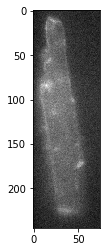

In [38]:
from skimage import io
vid0 = io.imread("../Data/Cell1/video0/vid0.tif")
vid0_mask = io.imread("../Data/Cell1/video0/cellmask.tif")
plt.imshow(vid0[0],cmap='gray')
time_vid0 = np.arange(0, vid0.shape[0])/55.78 #time vector for vid0

### Estimate illumination heterogeneities

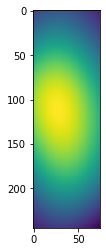

In [11]:
from skimage import filters as filt
from skimage import io
K_illumin = filt.gaussian(vid0[0],sigma=min((vid0.shape[1],vid0.shape[2]))//2)
plt.imshow(K_illumin)

### Normalize illumination

In [12]:
K_illumin2 = K_illumin*(1/np.amax(K_illumin))

### Make an inverse transformation on illumination to apply it onto video to compensate spatial variability due to illumination

In [45]:
min_K_illumin = np.amin(K_illumin2)
max_K_illumin = np.amax(K_illumin2)
delta_K_illumin = max_K_illumin - min_K_illumin

#Normalize K_illumin2
K_illumin_inv = (K_illumin2 - min_K_illumin)/(delta_K_illumin)

#Invert values
K_illumin_inv = 1 - K_illumin_inv

#Restore original values
K_illumin_inv = K_illumin_inv*(delta_K_illumin) + min_K_illumin

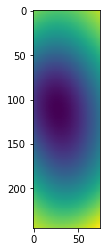

In [46]:
plt.imshow(K_illumin_inv)

### Before and after application of illumination heterogeneities correction

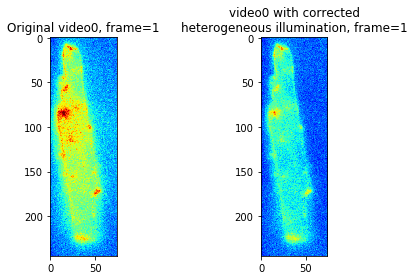

In [47]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(vid0[0],cmap='jet',vmin=3000,vmax=12000)
ax[0].set_title('Original video0, frame=1')
ax[1].imshow(K_illumin_inv*vid0[0],cmap='jet',vmin=3000,vmax=12000)
ax[1].set_title('video0 with corrected\nheterogeneous illumination, frame=1')
plt.tight_layout()

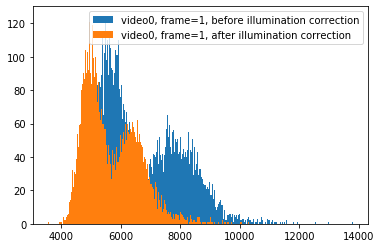

In [48]:
plt.hist(np.ravel(vid0[0]),bins=800,label='video0, frame=1, before illumination correction')
plt.hist(np.ravel(K_illumin_inv*vid0[0]),bins=800,label='video0, frame=1, after illumination correction')
plt.legend()

## Load a cell mask (scaled from experimental data Cell2)
### (to avoid confusion with Cell1 experimental data results)

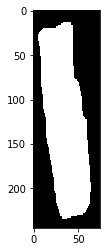

In [17]:
cell_mask = io.imread('./newcellmask.tif')
plt.imshow(cell_mask, cmap='gray')

### Get experimental data (video0) mean and standard deviation for each frame outside cell and inside cell
### These parameters will be used to generate basal fluorescence levels (from fluorescence means) 

In [49]:
vid0_illum_corr = K_illumin_inv*vid0 #Aplly illumination correction

spatial_F_mean_BG = np.mean(vid0[:,cell_mask==0],axis=1)
spatial_F_mean_CELL = np.mean(vid0[:,cell_mask>0],axis=1)

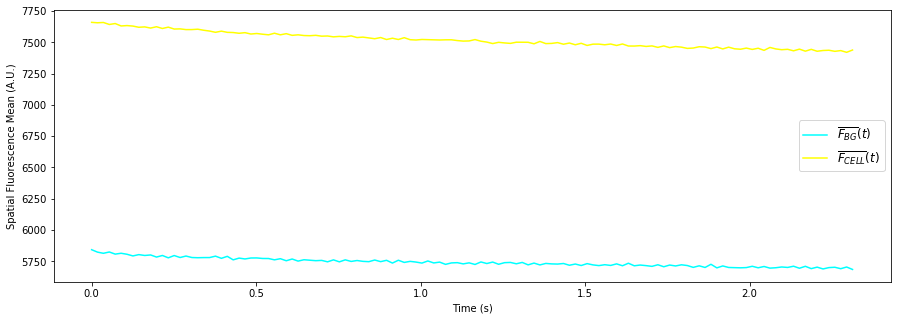

In [50]:
fig, ax = plt.subplots(1,1,figsize=[15,5])
ax.plot(time_vid0,spatial_F_mean_BG,label=r'$\overline{F_{BG}}(t)$',color='cyan')
ax.plot(time_vid0,spatial_F_mean_CELL,label=r'$\overline{F_{CELL}}(t)$',color='yellow')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spatial Fluorescence Mean (A.U.)')
ax.legend(fontsize='large')

#### fix photobleaching

In [20]:
def monoexp_and_line(x, a, b, c, d):
    return a * np.exp(-b * x) - (c * x) + d
#Fit exponentials
def fix_photob(data,time):

    def monoexp_and_line(x, a, b, c, d):
        return a * np.exp(-b * x) - (c * x) + d
 
    from scipy.optimize import curve_fit
    photobleaching = data
    plt.figure(figsize=[15,5])
    plt.plot(time,photobleaching)
    y0 = np.mean(photobleaching[0:5])
    yf = np.mean(photobleaching[-5:])

    #LINEAR FIT
    c, d = np.polyfit(time,photobleaching,1)
    p = np.poly1d((c,d))

    plt.plot(time,p(time),'r-.',label='linearfit: a=%5.3f, b=%5.3f' % (c,d))
    res1 = photobleaching - p(time)

   
    #EXPONENTIAL AND LINE
    upper_bounds = [2*(y0-yf), -2*(np.log(y0-yf)-np.log(d-(c*yf)-c)), 2*(abs(c)), 2*yf]
    print(upper_bounds)
    popt, pcov = curve_fit(monoexp_and_line, time, photobleaching, bounds=(0, upper_bounds))

    plt.plot(time, monoexp_and_line(time, *popt), 'c-.', label='expandlinfit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
    res2 = photobleaching - monoexp_and_line(time, *popt)

    plt.legend()
    return(popt)

[251.70616977225836, 15.438588154365531, 97.41115504757322, 11394.736149068322]
[443.63593803786534, 16.054708441706296, 180.82154664080903, 14862.247710843372]


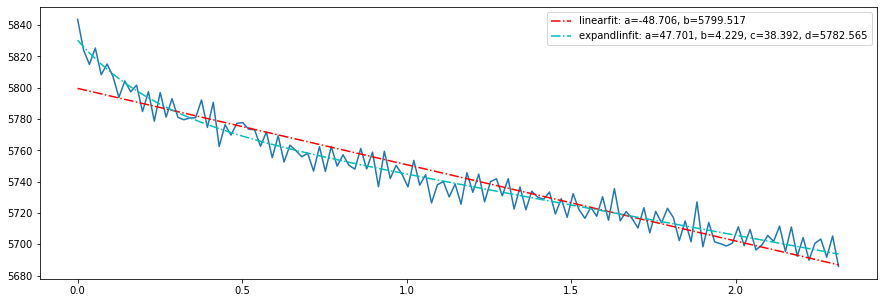

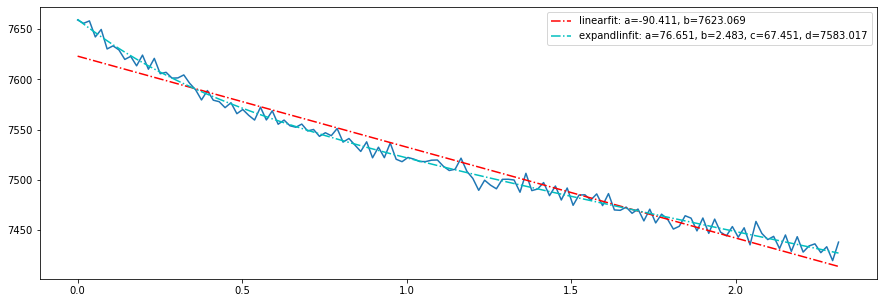

In [51]:
popt1 = fix_photob(spatial_F_mean_BG,time_vid0) #BG Fluorescence mean
popt2 = fix_photob(spatial_F_mean_CELL,time_vid0) #CELL Fluorescence mean

In [52]:
spatial_F_mean_BG -= monoexp_and_line(time_vid0, *popt1)
spatial_F_mean_BG += popt1[-1] #Adds back DC level
spatial_F_mean_CELL -= monoexp_and_line(time_vid0, *popt2)
spatial_F_mean_CELL += popt2[-1] #Adds back DC level

5782.565286058922
7583.017354616106


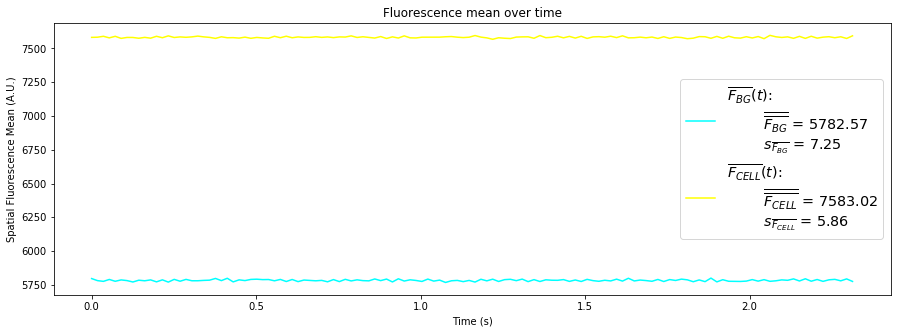

In [53]:
fig, ax = plt.subplots(1,1,figsize=[15,5])
label1 = r'$\overline{F_{BG}}(t)$:' + '\n\t' + r'$\overline{\overline{F_{BG}}}$ = ' + str(np.around(np.mean(spatial_F_mean_BG),decimals=2)) + '\n\t' + r'$s_{\overline{F_{BG}}}$ = ' + str(np.around(np.std(spatial_F_mean_BG),decimals=2))
ax.plot(time_vid0,spatial_F_mean_BG,label=label1,color='cyan')
label2 = r'$\overline{F_{CELL}}(t)$:' + '\n\t' + r'$\overline{\overline{F_{CELL}}}$ = ' + str(np.around(np.mean(spatial_F_mean_CELL),decimals=2)) + '\n\t' + r'$s_{\overline{F_{CELL}}}$ = ' + str(np.around(np.std(spatial_F_mean_CELL),decimals=2))
ax.plot(time_vid0,spatial_F_mean_CELL,label=label2,color='yellow')
ax.legend(fontsize='x-large')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spatial Fluorescence Mean (A.U.)')
ax.set_title('Fluorescence mean over time')
print(np.mean(spatial_F_mean_BG))
print(np.mean(spatial_F_mean_CELL))

In [54]:
#These will be used to make basal fluorescence
grand_mean_F_BG = np.mean(spatial_F_mean_BG)
std_mean_F_BG = np.std(spatial_F_mean_BG)
grand_mean_F_CELL = np.mean(spatial_F_mean_CELL)
std_mean_F_CELL = np.std(spatial_F_mean_CELL)

print('BG mean variation (mean +/- std) = ',grand_mean_F_BG, ' +/- ', std_mean_F_BG)
print('CELL mean variation (mean +/- std) = ',grand_mean_F_CELL, ' +/- ', std_mean_F_CELL)

BG mean variation (mean +/- std) =  5782.565286058922  +/-  7.245599737183503
CELL mean variation (mean +/- std) =  7583.017354616106  +/-  5.856899812591744


### Generate basal fluorescence image (depicting dye concentration distribution and illumination heterogeneities)

In [41]:
BF = np.zeros_like(cell_mask,dtype=float)
illum_gain_compensation = (1, 1)
BF[cell_mask==0] = grand_mean_F_BG*K_illumin2[cell_mask==0]*illum_gain_compensation[0] #+ smooth_gain_compensation[0]*std_mean_F_BG*np.random.randn(len(cell_mask[cell_mask==0]))
BF[cell_mask>0] = grand_mean_F_CELL*K_illumin2[cell_mask>0]*illum_gain_compensation[1] #+ smooth_gain_compensation[1]*std_mean_F_CELL*np.random.randn(len(cell_mask[cell_mask>0]))

print('BF Background mean = ',np.mean(BF[cell_mask==0]))
print('BF Cell mean = ',np.mean(BF[cell_mask>0]))

illum_gain_compensation = (1.14, 1.06)
BF[cell_mask==0] = grand_mean_F_BG*K_illumin2[cell_mask==0]*illum_gain_compensation[0] #+ smooth_gain_compensation[0]*std_mean_F_BG*np.random.randn(len(cell_mask[cell_mask==0]))
BF[cell_mask>0] = grand_mean_F_CELL*K_illumin2[cell_mask>0]*illum_gain_compensation[1] #+ smooth_gain_compensation[1]*std_mean_F_CELL*np.random.randn(len(cell_mask[cell_mask>0]))
print('Background mean of video0 = ',np.mean(vid0[0,vid0_mask==0]))
print('Cell mean of video0 = ',np.mean(vid0[0,vid0_mask>0]))
print('Adjusted BF Background mean (to match video0 mean) = ',np.mean(BF[cell_mask==0]))
print('Adjusted BF Cell mean (to match video0 mean) = ',np.mean(BF[cell_mask>0]))

BF Background mean =  5078.0990759245915
BF Cell mean =  7090.266198838325
Background mean of video0 =  5751.622140364482
Cell mean of video0 =  7924.610125325723
Adjusted BF Background mean (to match video0 mean) =  5789.0329465540335
Adjusted BF Cell mean (to match video0 mean) =  7515.682170768626


### Small gaussian blur to smooth transition from cell to BG

In [32]:
from skimage import filters as filt
BF = filt.gaussian(BF,sigma=2)

In [33]:
import scipy.ndimage as sm
print(np.mean(BF[np.invert(sm.binary_dilation(cell_mask,iterations=3))>0]))
print(np.mean(BF[sm.binary_erosion(cell_mask,iterations=3)>0]))

5761.14198409647
7542.1668773059555


Text(0.5, 1.0, 'Basail Fluorescence image')

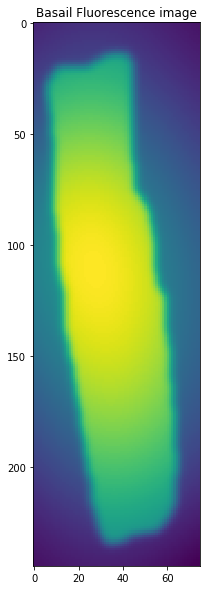

In [35]:
plt.figure(figsize=[10,10])
plt.imshow(BF)
plt.title('Basail Fluorescence image')

### Subtract a constant to equalize mean of BF with the mean of the last frames of Experimental data (Cell1, video0), which is 6304

In [36]:
print(np.mean(BF))
constant = np.mean(BF) - 6304
BF -= constant
print(np.mean(BF))

6607.694206973357
6303.999999999998


In [37]:
constant

303.6942069733568

### Generate noise variance matrix/image (depicting each pixel noise variation due to shot noise)

In [55]:
#Spatial average of the time variability (inside CELL)
spatial_mean_of_time_std_CELL = np.mean(np.std(vid0_illum_corr[:,cell_mask>0],axis=0))
print(spatial_mean_of_time_std_CELL)
#Spatial variability of the time variability (inside CELL)
spatial_std_of_time_std_CELL = np.std(np.std(vid0_illum_corr[:,cell_mask>0],axis=0))
print(spatial_std_of_time_std_CELL)

#Spatial average of the time variability (in BACKGROUND)
spatial_mean_of_time_std_BG = np.mean(np.std(vid0_illum_corr[:,cell_mask==0],axis=0))
print(spatial_mean_of_time_std_BG)
#Spatial variability of the time variability (in BACKGROUND)
spatial_std_of_time_std_BG = np.std(np.std(vid0_illum_corr[:,cell_mask==0],axis=0))
print(spatial_std_of_time_std_BG)

321.9718263868834
29.757952452412123
297.93572428181807
27.131107526314217


In [43]:
std_img = np.zeros_like(cell_mask,dtype=float)

std_img[cell_mask==0] = spatial_std_of_time_std_BG*np.random.randn(len(cell_mask[cell_mask==0])) + spatial_mean_of_time_std_BG
std_img[cell_mask>0] = spatial_std_of_time_std_CELL*np.random.randn(len(cell_mask[cell_mask>0])) + spatial_mean_of_time_std_CELL

var_img = std_img**2

Text(0.5, 1.0, 'Variance matrix/image')

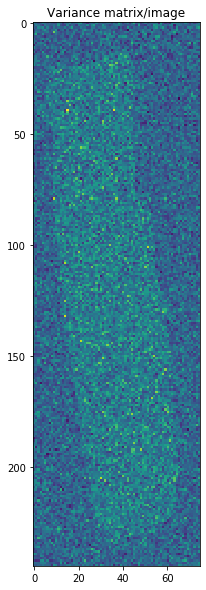

In [56]:
plt.figure(figsize=[10,10])
plt.imshow(var_img)
plt.title('Variance matrix/image')

## Generate Pure Signal video

### Create a sinusoidal gain function to be applied to signal_peak (to simulate electric field heterogeneous depolarization around cell)

In [61]:
#Get central point of shape
from skimage.measure import label, regionprops
label_mask = label(cell_mask)
regions = regionprops(label_mask)
for props in regions:
    cent_row, cent_col = props.centroid
centroid = (cent_row,cent_col)
centroid = np.around(centroid,0).astype(int)
rows,cols = np.indices((cell_mask.shape[0],cell_mask.shape[1]))
centroid_row_img = np.ones_like(rows)*centroid[0]
centroid_col_img = np.ones_like(cols)*centroid[1]

### Create an image (same shape as cell_mask) where each pixel has the angle with respect to centroid

In [69]:
angles_img = np.arctan2((centroid_row_img-rows),(cols-centroid_col_img)) + np.pi/2

### Create pure electroporation video

In [70]:
Delta_Vm_teta = E * ((R2diff)/(R1 - ((R2**2)/np.sqrt(R2diff))*np.log((R1 + np.sqrt(R2diff))/R2))) * ((R2*np.cos(angles_img))/np.sqrt(((R1**2)*(np.sin(angles_img)**2)) + ((R2**2)*(np.cos(angles_img)**2))))
Delta_Vm_teta = np.around(Delta_Vm_teta,6)
Delta_Vm_teta = np.repeat(Delta_Vm_teta[np.newaxis,:],len(time_sub),axis=0)

time_sub_shifted = np.roll(time_sub,i2_5_sub) 
time_sub_vid = np.repeat(time_sub_shifted[:,np.newaxis], cell_mask.shape[1], axis=1)
time_sub_vid = np.repeat(time_sub_vid[:,np.newaxis], cell_mask.shape[0], axis=1)

#Exponential decay after peak
Delta_Vm_teta_t = np.zeros_like(Delta_Vm_teta)
Delta_Vm_teta_t[Delta_Vm_teta!=0] = Delta_Vm_teta[Delta_Vm_teta!=0]*np.exp(np.log(0.001/abs(Delta_Vm_teta[Delta_Vm_teta!=0]))*(time_sub_vid[Delta_Vm_teta!=0]/0.05))

#Extracellular space should be zero
Delta_Vm_teta_t[:,cell_mask==0] = 0

#Adds resting potential (-80mV) to intracellular space
Delta_Vm_teta_t[:i2_5_sub,cell_mask!=0] -= 0.08

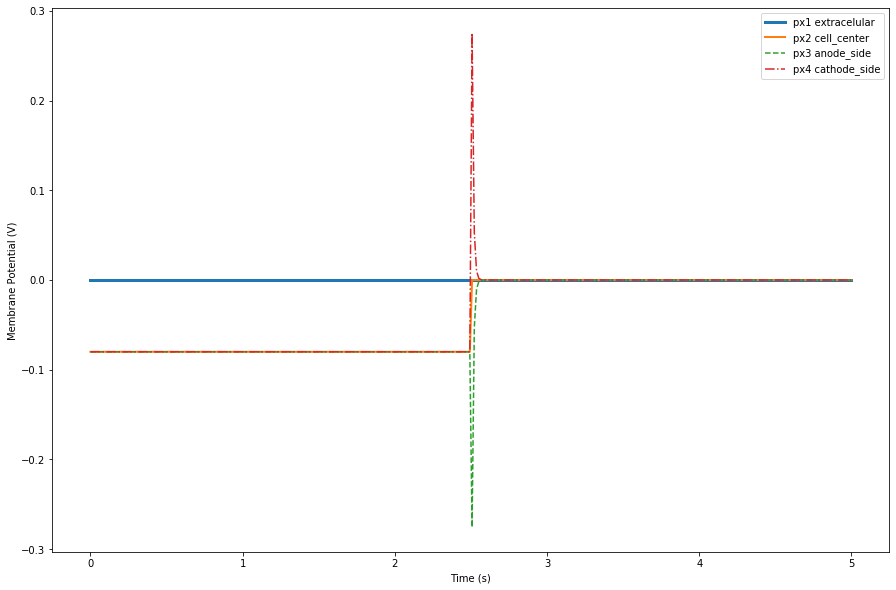

In [71]:
plt.figure(figsize=[15,10])
plt.plot(time_sub,Delta_Vm_teta_t[:,0,0],lw=3,label='px1 extracelular')
plt.plot(time_sub,Delta_Vm_teta_t[:,125,36],lw=2,label='px2 cell_center')
plt.plot(time_sub,Delta_Vm_teta_t[:,14,35],'--',label='px3 anode_side')
plt.plot(time_sub,Delta_Vm_teta_t[:,230,35],'-.',label='px4 cathode_side')
plt.xlabel('Time (s)')
plt.ylabel('Membrane Potential (V)')
plt.legend()

#### Normalize video

In [72]:
Delta_Vm_teta_t_norm = np.zeros_like(Delta_Vm_teta_t)
Delta_Vm_teta_t_norm[:,cell_mask!=0] = Delta_Vm_teta_t[:,cell_mask!=0] + 0.08    #shift amp from ~-80 to 0
Delta_Vm_teta_t_norm = -Delta_Vm_teta_t_norm/np.amax(Delta_Vm_teta_t_norm)    #normalize amplitude

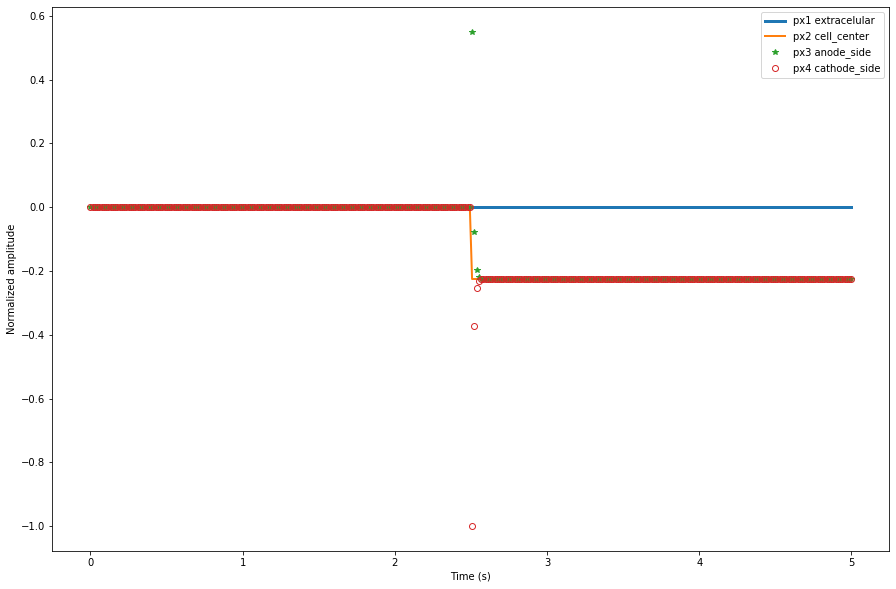

In [73]:
plt.figure(figsize=[15,10])
plt.plot(time_sub,Delta_Vm_teta_t_norm[:,0,0],lw=3,label='px1 extracelular')
plt.plot(time_sub,Delta_Vm_teta_t_norm[:,125,36],lw=2,label='px2 cell_center')
plt.plot(time_sub,Delta_Vm_teta_t_norm[:,14,35],'*',label='px3 anode_side')
plt.plot(time_sub,Delta_Vm_teta_t_norm[:,230,35],'o',markerfacecolor='none',label='px4 cathode_side')
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.legend()

#### Modulate video with BF

In [74]:
signal_vid = np.zeros((n_samples,cell_mask.shape[0],cell_mask.shape[1]))
signal_vid[:,cell_mask>0] = BF[cell_mask>0]*Delta_Vm_teta_t_norm[:,cell_mask>0]

Max value from video mean= 802.5150948292604
Signal power of px2 cell_center= 1616242.1942067617
Signal power of px3 anode_side= 1206379.477769888
Signal power of px4 cathode_side= 1265122.0438384558
Signal power of video_mean= 321864.1646234513


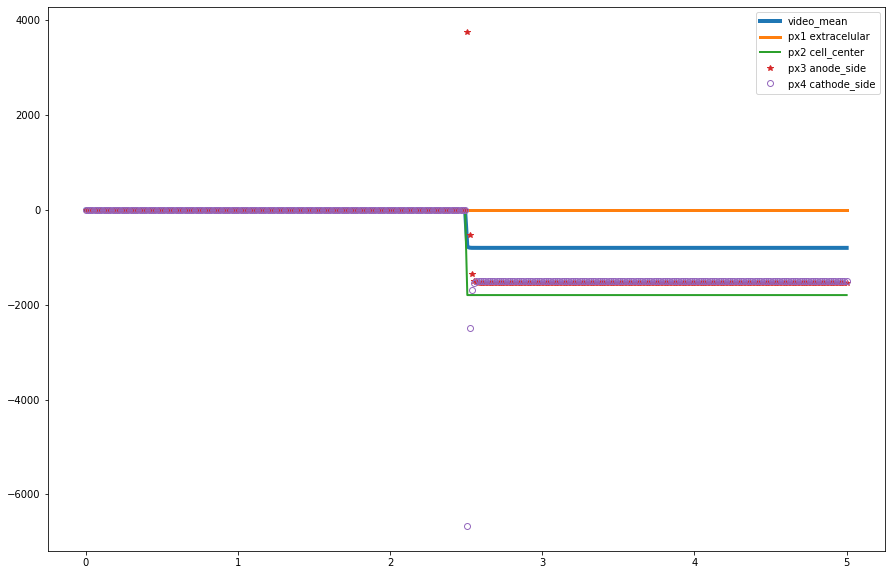

In [83]:
plt.figure(figsize=[15,10])
plt.plot(time_sub,np.mean(signal_vid,axis=(1,2)),lw=4,label='video_mean')
plt.plot(time_sub,signal_vid[:,0,0],lw=3,label='px1 extracelular')
plt.plot(time_sub,signal_vid[:,125,36],lw=2,label='px2 cell_center')
plt.plot(time_sub,signal_vid[:,14,35],'*',label='px3 anode_side')
plt.plot(time_sub,signal_vid[:,230,35],'o',markerfacecolor='none',label='px4 cathode_side')

print('Max value from video mean=',np.amax(abs(np.mean(signal_vid,axis=(1,2)))))
print('Signal power of px2 cell_center=',np.sum(np.square(abs(signal_vid[:,125,36])),axis=0)/(signal_vid.shape[0]))
print('Signal power of px3 anode_side=',np.sum(np.square(abs(signal_vid[:,14,35])),axis=0)/(signal_vid.shape[0]))
print('Signal power of px4 cathode_side=',np.sum(np.square(abs(signal_vid[:,230,35])),axis=0)/(signal_vid.shape[0]))
print('Signal power of video_mean=',np.sum(np.square(abs(np.mean(signal_vid,axis=(1,2)))))/(signal_vid.shape[0]))
plt.legend()

#### Generate an image whose coordinates contain respective pixel signal power

In [84]:
signal_power_img = np.zeros_like(BF)

signal_power_img[cell_mask>0] = np.sum(np.square(abs(signal_vid[:,cell_mask>0])),axis=0)/(signal_vid.shape[0])

In [85]:
print('Signal power of px2 cell_center=',signal_power_img[125,36])
print('Signal power of px3 anode_side=',signal_power_img[14,35])
print('Signal power of px4 cathode_side=',signal_power_img[230,35])

Signal power of px2 cell_center= 1616242.1942067617
Signal power of px3 anode_side= 1206379.477769888
Signal power of px4 cathode_side= 1265122.0438384558


# Here we have a video with signal inside cell modulated by BF (Basal Fluorescence)
# Now let's get ROIs means

### Divide mask with MESS and get ROIs means (from pure signal video)

In [218]:
import sys,os
    
metroidpath = os.path.abspath('../')
if metroidpath not in sys.path:
    sys.path.append(metroidpath)
items = os.listdir(metroidpath)
if 'MESS.py' not in items:
    ! jupyter nbconvert --to python ../MESS.ipynb --output-dir ../

import MESS as mes
ROIs_masks, label_ROIs, ROIs_means_signal, time   = mes.segment(cell_mask, signal_vid, 1/time_sub[1])

In [88]:
nregions = np.amax(label_ROIs).astype(int)
ncolors = nregions
from matplotlib import cm
from matplotlib.colors import ListedColormap
brg = cm.get_cmap('brg', nregions)
newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
newcolors = newcolors[:nregions]
newcolors = brg(newcolors)
black = np.array([0, 0, 0, 1])
newcolors = np.insert(newcolors,0,black,axis=0)
newcmp = ListedColormap(newcolors)

(-0.5, 74.5, 244.5, -0.5)

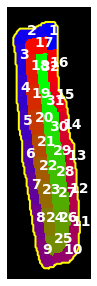

In [89]:
fig, ax = plt.subplots(figsize=[5,5],nrows=1, ncols=1)
ax.imshow(label_ROIs, cmap=newcmp)
cent_coord = np.zeros((nregions,2))
contour = mes.build_contour(cell_mask)
for j in range(nregions):
    cent_coord[j,:] = np.rint(mes.get_centroid(ROIs_masks[j,:,:]))
    ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=14,weight='bold') 
ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axis('off')

## Create Pure Noise video

Noise video shape= (340, 245, 75)


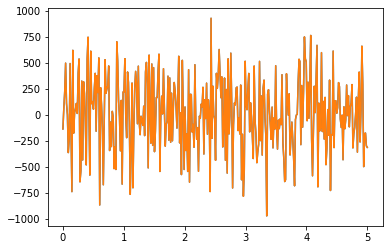

In [90]:
# Generate a sample data
np.random.seed(1085) #14lines*75columns + 35columns
noise_sample = np.random.poisson(lam=var_img[14,35],size=time_sub.shape) - var_img[14,35]
plt.plot(time_sub, noise_sample)

# Generate noise video
noise_vid = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
# Generate noise power image
noise_power_img = np.zeros_like(var_img)
for i in range(signal_vid.shape[1]):
    for j in range(signal_vid.shape[2]):
        #each pixel noise is independently generated
        np.random.seed((signal_vid.shape[2]*i)+j)
        #each pixel noise comes from poisson distribution with std from respective experimental pixel data
        noise_vid[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
        #calculates each pixel noise power
        noise_power_img[i,j] = np.sum(np.square(abs(noise_vid[:,i,j])),axis=0)/(noise_vid.shape[0])
#checks if sample noise and pixel (x=30,y=30) are the same
plt.plot(time_sub, noise_vid[:,14,35])
print('Noise video shape=',noise_vid.shape)

In [91]:
print('Var of px2 cell_center=',var_img[125,36])
print('Noise power of cell_center=',noise_power_img[125,36])
print('Var of px3 anode_side=',var_img[14,35])
print('Noise power of px3 anode_side=',noise_power_img[14,35])
print('Var of px4 cathode_side=',var_img[230,35])
print('Noise power of px4 cathode_side=',noise_power_img[230,35])

Var of px2 cell_center= 117025.2287643903
Noise power of cell_center= 119777.9511077339
Var of px3 anode_side= 118557.4933907977
Noise power of px3 anode_side= 121113.074362614
Var of px4 cathode_side= 103731.36597116609
Noise power of px4 cathode_side= 106164.55251227295


### Divide mask with MESS and get ROIs means (from pure noise video)

In [92]:
ROIs_masks, label_ROIs, ROIs_means_noise, time   = mes.segment(cell_mask, noise_vid, 1/time_sub[1])

## Check current ROIs SNR

SNR= 2927.6495
SNR (dB)= 34.67
SNR= 3570.6171
SNR (dB)= 35.53
SNR= 3177.5213
SNR (dB)= 35.02
SNR= 4041.321
SNR (dB)= 36.07
SNR= 3320.9099
SNR (dB)= 35.21
SNR= 3612.8977
SNR (dB)= 35.58
SNR= 3471.9333
SNR (dB)= 35.41
SNR= 3857.4998
SNR (dB)= 35.86
SNR= 3542.6476
SNR (dB)= 35.49
SNR= 4388.3589
SNR (dB)= 36.42
SNR= 3508.3086
SNR (dB)= 35.45
SNR= 3750.125
SNR (dB)= 35.74
SNR= 3078.5294
SNR (dB)= 34.88
SNR= 4420.741
SNR (dB)= 36.45
SNR= 3557.0971
SNR (dB)= 35.51
SNR= 3635.5967
SNR (dB)= 35.61
SNR= 3743.5953
SNR (dB)= 35.73
SNR= 3763.3746
SNR (dB)= 35.76
SNR= 3311.2231
SNR (dB)= 35.2
SNR= 4366.0076
SNR (dB)= 36.4
SNR= 3951.4304
SNR (dB)= 35.97
SNR= 4710.4567
SNR (dB)= 36.73
SNR= 3900.5693
SNR (dB)= 35.91
SNR= 3713.6264
SNR (dB)= 35.7
SNR= 3469.7414
SNR (dB)= 35.4
SNR= 3486.5467
SNR (dB)= 35.42
SNR= 4693.0391
SNR (dB)= 36.71
SNR= 4047.1248
SNR (dB)= 36.07
SNR= 4498.6055
SNR (dB)= 36.53
SNR= 4526.5396
SNR (dB)= 36.56
SNR= 4815.517
SNR (dB)= 36.83
SNR= 4307.6316
SNR (dB)= 36.34


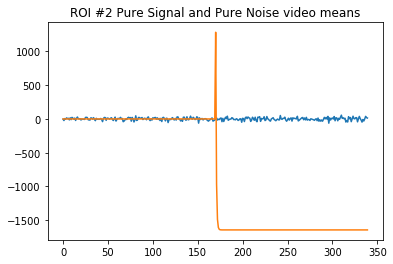

In [93]:
N = np.zeros((nregions))
P = np.zeros((nregions))
for i in range(nregions):
    P[i] = np.sum(np.square(abs(ROIs_means_signal[:,i])),axis=0)/(n_samples) #Power in each ROI for pure AP video
    N[i] = np.sum(np.square(abs(ROIs_means_noise[:,i])),axis=0)/(n_samples)
    SNR = P[i]/N[i]
    SNR_dB = 10*np.log10(SNR)
    print('SNR=',np.around(SNR,decimals=4))
    print('SNR (dB)=',np.around(SNR_dB,decimals=2))
plt.title('ROI #2 Pure Signal and Pure Noise video means')
plt.plot(ROIs_means_noise[:,2])
plt.plot(ROIs_means_signal[:,2])

### Calculate each pixel signal gain necessary to reach desired ROI SNR
### SNR mean and SD obtained from experimental data (Cell1 video3: EP signal)

#### Calculate ROIs areas in number of pixels to estimate signal averaging

In [95]:
for i in range(nregions+1):
    region_area_px = len(label_ROIs[label_ROIs==i])
    region_area_perc = region_area_px/(np.size(label_ROIs))
    region_area_perc *= 100

In [96]:
np.random.seed(2280)
if SNR_distribution == 'uniform':
    Desired_SNR_dB_vector = np.repeat(Desired_SNR_dB,nregions)
elif SNR_distribution == 'normal':
    Desired_SNR_dB_vector = Desired_SNR_SD_dB*np.random.randn(nregions) + Desired_SNR_dB
elif SNR_distribution =='BF_modulated':
    ROIs_means_BF = np.zeros(nregions)
    for i in range(nregions):
        ROIs_means_BF[i] = np.mean(BF[label_ROIs==i+1])
    norm_ROIs_means_BF = (ROIs_means_BF - np.amin(ROIs_means_BF))/(np.amax(ROIs_means_BF) - np.amin(ROIs_means_BF))
    Desired_SNR_dB_vector = (Desired_Max_SNR_dB - (Desired_Min_SNR_dB))*norm_ROIs_means_BF + Desired_Min_SNR_dB
    
Desired_SNR = 10**(Desired_SNR_dB_vector/10)
P = np.zeros((nregions))

gain_per_px_in_ROI = np.ones_like(var_img) #Average Noise gain per pixel inside each region

for i in range(nregions):
    P[i] = np.sum(np.square(abs(ROIs_means_signal[:,i])),axis=0)/(n_samples) #Power in each ROI for pure AP video

    ROI_area_px = len(label_ROIs[label_ROIs==i+1])  #each ROI area (in number of pixels)

    gain_per_px_in_ROI[label_ROIs==i+1] = np.sqrt(((Desired_SNR[i]*noise_power_img[label_ROIs==i+1])/(ROI_area_px*signal_power_img[label_ROIs==i+1])))


In [97]:
Desired_SNR

array([0.62, 0.64, 1.35, 3.81, 6.18, 5.17, 2.96, 1.24, 0.43, 0.35, 0.76,
       1.88, 3.29, 4.26, 3.53, 1.67, 0.98, 2.24, 4.91, 6.92, 6.67, 4.91,
       2.87, 1.32, 0.59, 1.16, 2.3 , 3.76, 5.18, 6.14, 5.09, 2.22])

#### Print three example pixel signal power

In [98]:
print('Signal power of px2 cell_center=',signal_power_img[125,36])
print('Signal power of px3 anode_side=',signal_power_img[14,35])
print('Signal power of px4 cathode_side=',signal_power_img[230,35])

Signal power of px2 cell_center= 1616242.1942067617
Signal power of px3 anode_side= 1206379.477769888
Signal power of px4 cathode_side= 1265122.0438384558


#### Print three example pixel noise power

In [99]:
print('Noise power of px2 cell_center=',noise_power_img[125,36])
print('Noise power of px3 anode_side=',noise_power_img[14,35])
print('Noise power of px4 cathode_side=',noise_power_img[230,35])


Noise power of px2 cell_center= 119777.9511077339
Noise power of px3 anode_side= 121113.074362614
Noise power of px4 cathode_side= 106164.55251227295


#### Print three example pixel signal gain

In [100]:
print('Gain of px2 cell_center=',gain_per_px_in_ROI[125,36])
print('Gain of px3 anode_side=',gain_per_px_in_ROI[14,35])
print('Gain of px4 cathode_side=',gain_per_px_in_ROI[230,35])

Gain of px2 cell_center= 0.035599383241680875
Gain of px3 anode_side= 0.016017397433829503
Gain of px4 cathode_side= 0.011887294997379913


#### Print three example pixel snr and expected new snr after gain

In [101]:
print('snr (dB) before gain of px2 cell_center=',10*np.log10(signal_power_img[125,36]/noise_power_img[125,36]))
print('snr (dB) before gain of px3 anode_side=',10*np.log10(signal_power_img[14,35]/noise_power_img[14,35]))
print('snr (dB) before gain of px4 cathode_side=',10*np.log10(signal_power_img[230,35]/noise_power_img[230,35]))
print('snr (dB) after gain of px2 cell_center=',10*np.log10(np.power(gain_per_px_in_ROI[125,36],2)*signal_power_img[125,36]/noise_power_img[125,36]))
print('snr (dB) after gain of px3 anode_side=',10*np.log10(np.power(gain_per_px_in_ROI[14,35],2)*signal_power_img[14,35]/noise_power_img[14,35]))
print('snr (dB) after gain of px4 cathode_side=',10*np.log10(np.power(gain_per_px_in_ROI[230,35],2)*signal_power_img[230,35]/noise_power_img[230,35]))

snr (dB) before gain of px2 cell_center= 11.301295605507944
snr (dB) before gain of px3 anode_side= 9.982929121193019
snr (dB) before gain of px4 cathode_side= 10.761528895442131
snr (dB) after gain of px2 cell_center= -17.66985491652609
snr (dB) after gain of px3 anode_side= -25.925231844776082
snr (dB) after gain of px4 cathode_side= -27.736810297066967


### Apply gain to pure EP vid with necessary pixel amplitude gain to result in Desired ROI SNR

In [102]:
signal_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))

signal_power_img2 = np.zeros_like(var_img)

signal_vid2 = signal_vid*gain_per_px_in_ROI

signal_power_img2 = np.sum(np.square(abs(signal_vid2)),axis=0)/(signal_vid2.shape[0])

### Divide mask with MESS and get ROIs means (from adjusted pure signal video)

In [103]:
ROIs_masks, label_ROIs, ROIs_means_signal2, time   = mes.segment(cell_mask, signal_vid2, 1/time_sub[1])

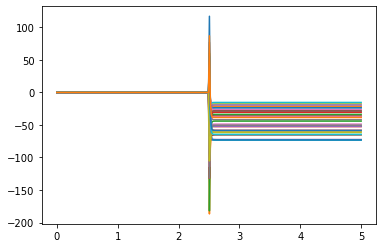

In [105]:
plt.plot(time,ROIs_means_signal2)

## Calculate ROIs adjusted signal power and adjusted SNR and plot an example ROI mean over time for adjusted pure signal and pure noise

SNR= 0.6269625802999514
SNR (dB)= -2.0275837887295847
SNR= 0.6573669621872461
SNR (dB)= -1.8219212638813347
SNR= 1.3460189102313171
SNR (dB)= 1.2905116133775207
SNR= 3.6775423046035356
SNR (dB)= 5.655576773343602
SNR= 5.425521351477459
SNR (dB)= 7.344414769336211
SNR= 4.911942338880102
SNR (dB)= 6.9125325999525
SNR= 2.792951137325968
SNR (dB)= 4.460633377864577
SNR= 1.2547059346456353
SNR (dB)= 0.985419521713553
SNR= 0.4753530177489529
SNR (dB)= -3.2298374465386495
SNR= 0.46361773891472424
SNR (dB)= -3.338399554405502
SNR= 0.8033884202663689
SNR (dB)= -0.9507443231390783
SNR= 1.9345028973595693
SNR (dB)= 2.8656938451284955
SNR= 2.7879940014981615
SNR (dB)= 4.452918350217212
SNR= 4.884729820823553
SNR (dB)= 6.888405474671937
SNR= 3.2022418391118466
SNR (dB)= 5.054541275288394
SNR= 1.715138060530688
SNR (dB)= 2.3429908444489786
SNR= 1.0248392334226077
SNR (dB)= 0.1065574293959181
SNR= 2.3302686629673937
SNR (dB)= 3.6740599489634636
SNR= 4.024646344658844
SNR (dB)= 6.04727723881242
SNR= 7

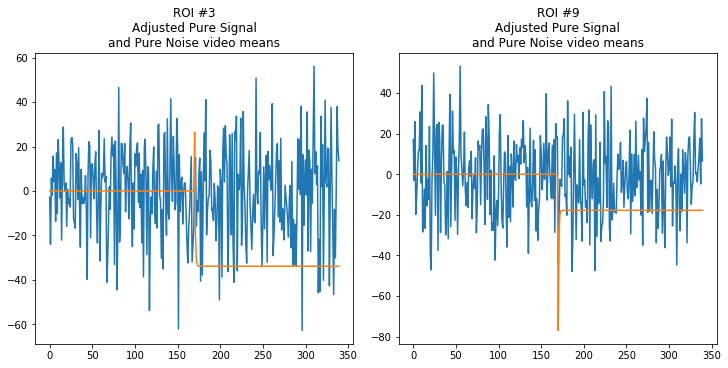

In [107]:
P2 = np.zeros_like(P)
for i in range(nregions):
    P2[i] = np.sum(np.square(abs(ROIs_means_signal2[:,i])),axis=0)/(n_samples)
    SNR = P2[i]/N[i]
    SNR_dB = 10*np.log10(SNR)
    print('SNR=',SNR)
    print('SNR (dB)=',SNR_dB)
fig, ax = plt.subplots(1,2,constrained_layout=True,figsize=[10,5])
ax[0].set_title('ROI #3\nAdjusted Pure Signal\nand Pure Noise video means')
ax[0].plot(ROIs_means_noise[:,2])
ax[0].plot(ROIs_means_signal2[:,2])
ax[1].set_title('ROI #9\nAdjusted Pure Signal\nand Pure Noise video means')
ax[1].plot(ROIs_means_noise[:,8])
ax[1].plot(ROIs_means_signal2[:,8])
print('SNR_dB mean=',np.mean(SNR_dB))

# Generate artificial video without photobleaching

In [108]:
artificial_video = np.zeros_like(noise_vid)
artificial_video += Basal_fluorescence_switch*np.repeat(BF[np.newaxis,:],len(time_sub),axis=0) #K_BF
artificial_video += Signal_switch*signal_vid2 # + K_BF*signal
artificial_video += Poisson_noise_switch*noise_vid # + Poisson Noise

artificial_video = np.around(artificial_video).astype('uint16')

In [109]:
np.mean(artificial_video)

6597.530809763905

## save video wihtout photobleaching

In [110]:
# art_vid_path = "./Output_EP_video/artificial_video_EP_nophotob.tif"
# io.imsave(art_vid_path,artificial_video.astype('uint16'),plugin='tifffile')

## Photobleaching

## Get global photobleaching parameters from experimental data (Cell1, video0)

In [111]:
#PHOTOBLEACHING (parameters got from video1 global photobleaching curve_fittings: exp and lin gave less residues than
# liner, monoexponential and doubleexponential (wildly unstable this one btw))

# But choosing better initial guess for first exponential time constant based on exp+linear fit yielded less residues 
# with double exponential without overflowing any of the parameters
a = 43.1
b = 4.6
f = 353.7
g = 0.2
d = 6302.4
# s1_end = a*np.exp(-b*5) +e*np.exp(-f*5)
# print(s1_end)

Text(0.5, 1.0, 'Global photobleaching from Cell1 video0')

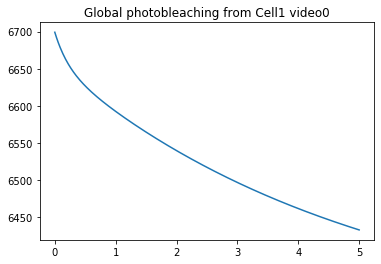

In [119]:
experimental_photob_function = a*np.exp(-b*time_sub) +f*np.exp(-g*time_sub) + d

plt.plot(time_sub,experimental_photob_function)
plt.title('Global photobleaching from Cell1 video0')

## Artificial video: AP signal + Photobleaching + Noise

In [120]:
default_photob_vid = np.repeat(experimental_photob_function[:,np.newaxis], cell_mask.shape[1], axis=1)
default_photob_vid = np.repeat(default_photob_vid[:,np.newaxis], cell_mask.shape[0], axis=1)
photob_vid_with_offset = (BF/np.amax(BF))*default_photob_vid #Default experimental photobleaching spatially modulated by BF

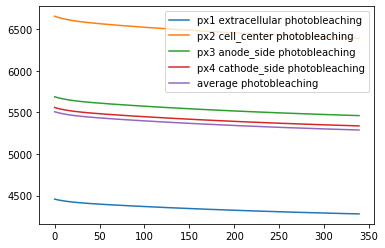

In [121]:
plt.plot(photob_vid_with_offset[:,0,0],label='px1 extracellular photobleaching')
plt.plot(photob_vid_with_offset[:,125,36],label='px2 cell_center photobleaching')
plt.plot(photob_vid_with_offset[:,14,35],label='px3 anode_side photobleaching')
plt.plot(photob_vid_with_offset[:,230,35],label='px4 cathode_side photobleaching')
plt.plot(np.mean(photob_vid_with_offset,axis=(1,2)),label='average photobleaching')
plt.legend()

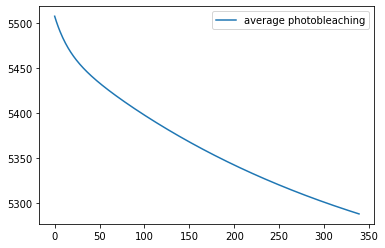

In [122]:
plt.plot(np.mean(photob_vid_with_offset,axis=(1,2)),label='average photobleaching')
plt.legend()

In [123]:
#Subtract offset to make average global photobleaching reach zero in the end of the video 
#  (some pixels will become negative in this video)
photob_vid = photob_vid_with_offset - np.mean(photob_vid_with_offset,axis=(1,2))[-1]

# Weight applied to make average global photobleaching equal to experimental data (Cell1, video0)
# Empirical 
W = 1.825
photob_vid= photob_vid*W

In [124]:
np.mean(photob_vid,axis=(1,2))[0]

400.1053612996426

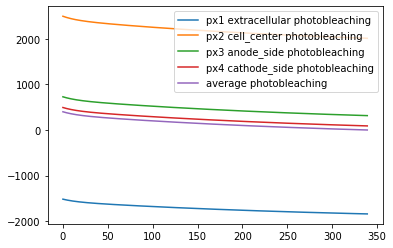

In [125]:
plt.plot(photob_vid[:,0,0],label='px1 extracellular photobleaching')
plt.plot(photob_vid[:,125,36],label='px2 cell_center photobleaching')
plt.plot(photob_vid[:,14,35],label='px3 anode_side photobleaching')
plt.plot(photob_vid[:,230,35],label='px4 cathode_side photobleaching')
plt.plot(np.mean(photob_vid,axis=(1,2)),label='average photobleaching')
plt.legend()

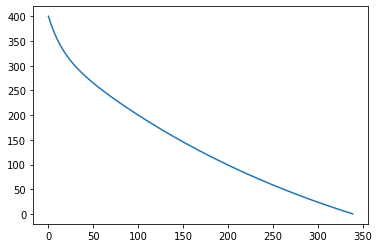

In [126]:
plt.plot(np.mean(photob_vid,axis=(1,2)),label='average photobleaching')

In [127]:
artificial_video2 = np.zeros_like(noise_vid)
artificial_video2 += Basal_fluorescence_switch*np.repeat(BF[np.newaxis,:],len(time_sub),axis=0) #BF
artificial_video2 += Signal_switch*signal_vid2 # + BF*signal
artificial_video2 += Photobleaching_switch*photob_vid # + BF*photob
artificial_video2 += Poisson_noise_switch*noise_vid # + Poisson Noise

artificial_video2 = np.around(artificial_video2).astype('uint16')

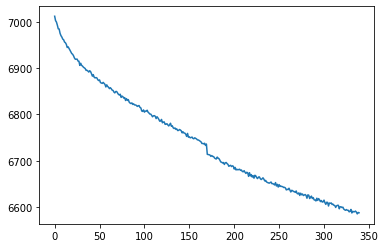

In [129]:
plt.plot(np.mean(artificial_video2,axis=(1,2)))

## Save video with photobleaching

In [130]:
art_vid_path = "./Output_EP_video/artificial_video_EP.tif"
io.imsave(art_vid_path,artificial_video2.astype('uint16'),plugin='tifffile')

# \_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_End of artificial video creation____________________

## Open Experimetnal data

In [133]:
from skimage import io
vid_cell1_EP = io.imread("../Data/Cell1/video_EP/vid3.tif")
cell_mask1 = io.imread("../Data/Cell1/video_EP/cellmask.tif")

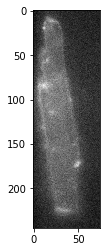

In [134]:
plt.imshow(vid_cell1_EP[0],cmap='gray')

In [135]:
# MESS on experimental data
ROIs_masks_cell1, label_ROIs_cell1, ROIs_means_cell1, time_cell1   = mes.segment(cell_mask1, vid_cell1_EP, 55.67)
# MESS ona rtificial data
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial, time_artificial   = mes.segment(cell_mask, artificial_video2, fs)

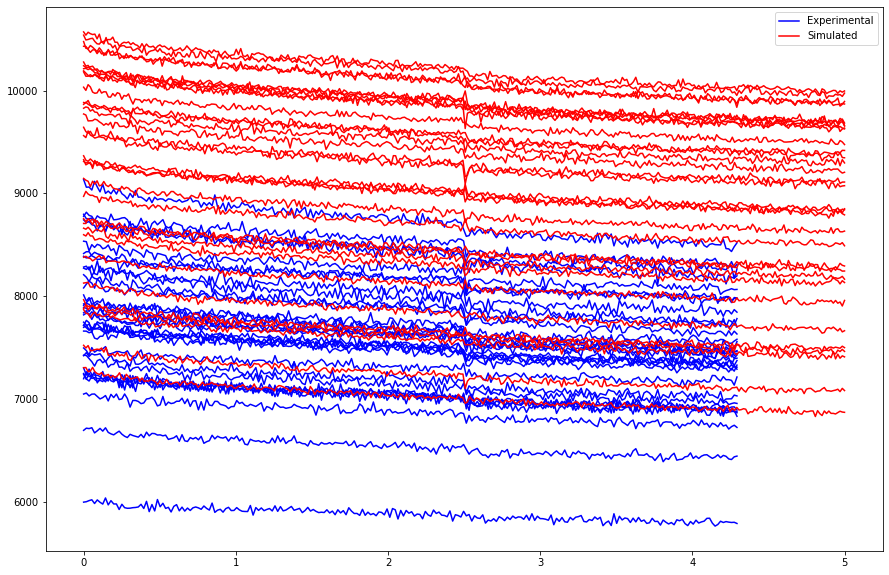

In [139]:
fig, ax = plt.subplots(1,1,figsize=[15,10])
a1 = ax.plot(time_cell1,ROIs_means_cell1,'b')
a2 = ax.plot(time_artificial,ROIs_means_artificial,'r')
ax.legend((a1[0],a2[0]),('Experimental','Simulated'))

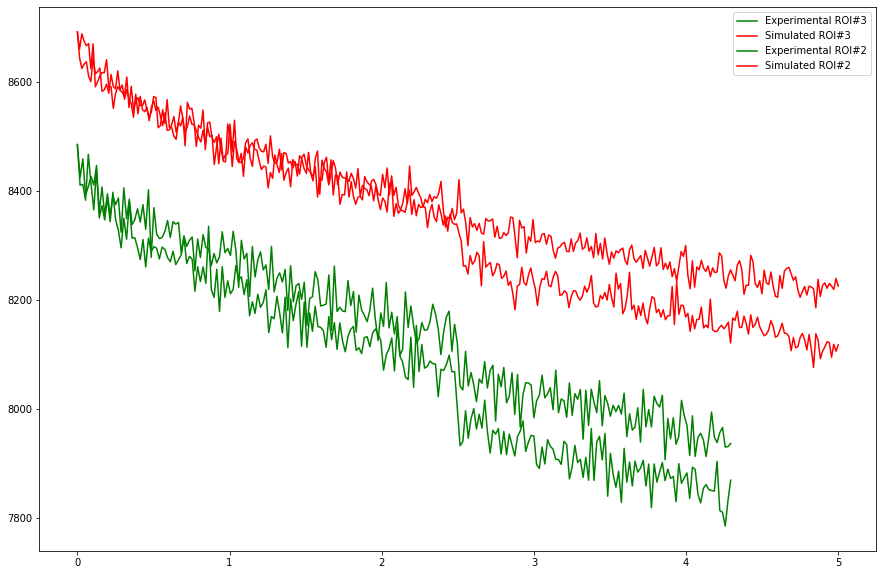

In [141]:
ROIs_means_cell1_samey0 = np.zeros_like(ROIs_means_cell1)
y0 = np.mean(ROIs_means_cell1[0][:5])
for i in range(nregions):
    ROIs_means_cell1_samey0[:,i] = ROIs_means_cell1[:,i] - (ROIs_means_cell1[0,i] - y0)
    
ROIs_means_artificial_samey0 = np.zeros_like(ROIs_means_artificial)
y0 = np.mean(ROIs_means_artificial[0][:5])
for i in range(nregions):
    ROIs_means_artificial_samey0[:,i] = ROIs_means_artificial[:,i] - (ROIs_means_artificial[0,i] - y0)
    
fig, ax = plt.subplots(1,1,figsize=[15,10])
ax.plot(time_cell1,ROIs_means_cell1_samey0[:,2],'g', label='Experimental ROI#3')
ax.plot(time_artificial,ROIs_means_artificial_samey0[:,19]-300,'r', label='Simulated ROI#3')
ax.plot(time_cell1,ROIs_means_cell1_samey0[:,1],'g', label='Experimental ROI#2')
ax.plot(time_artificial,ROIs_means_artificial_samey0[:,1]-300,'r', label='Simulated ROI#2')
plt.legend()

# \_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_Comparsion to other methods____________________

# True outputs

### Max amplitude

In [142]:
true_max_values = ROIs_means_signal2[max_idx_sub]

In [143]:
true_max_values

array([  52.91,   33.92,   26.52,   13.62,  -30.93,  -89.23, -130.77,
       -112.33,  -76.99,  -53.38,  -62.22,  -77.92,  -69.69,  -21.96,
         59.31,   76.85,   51.57,   56.37,   60.51,   30.57,  -74.77,
       -186.8 , -182.03, -132.09,  -76.24,  -93.34, -114.49, -131.66,
       -105.51,   55.2 ,  116.92,   86.86])

In [144]:
true_median_values = np.median(ROIs_means_signal2[i2_5_sub+3:],axis=0)

In [145]:
true_median_values

array([-22.94, -21.31, -33.83, -52.67, -72.49, -65.48, -48.82, -29.49,
       -17.75, -15.55, -24.02, -38.07, -52.1 , -58.4 , -52.16, -36.16,
       -26.67, -42.14, -61.74, -73.55, -73.1 , -59.07, -44.21, -30.64,
       -19.44, -28.23, -37.82, -50.45, -59.2 , -64.58, -58.56, -38.7 ])

### True waveforms

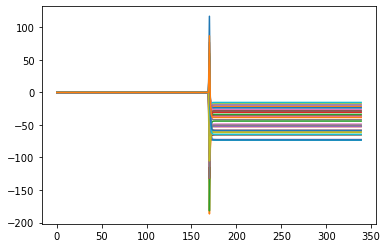

In [146]:
plt.plot(ROIs_means_signal2)

### RMSE is zero (there is no noise in pure signal)

# Blank Subtraction (BkS)

## Generate Blank Video

### Create Another Pure Noise video

Noise video shape= (340, 245, 75)


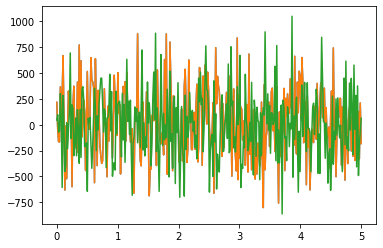

In [147]:
# Generate a sample data
np.random.seed(18375) #245lines*75columns
noise_sample2 = np.random.poisson(lam=var_img[0,0],size=time_sub.shape) - var_img[0,0]
plt.plot(time_sub, noise_sample2)

# Generate noise video
noise_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
# Generate noise power image
noise_power_img2 = np.zeros_like(var_img)
for i in range(vid0.shape[1]):
    for j in range(vid0.shape[2]):
        #each pixel noise is independently generated
        np.random.seed((vid0.shape[2]*i)+j+(vid0.shape[1]*vid0.shape[2]))
        #each pixel noise comes from poisson distribution with std from respective experimental pixel data
        noise_vid2[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
        #calculates each pixel noise power
        noise_power_img2[i,j] = np.sum(np.square(abs(noise_vid2[:,i,j])),axis=0)/(noise_vid2.shape[0])
#checks if sample noise and pixel (x=30,y=30) are the same
plt.plot(time_sub, noise_vid2[:,0,0])
plt.plot(time_sub, noise_vid[:,0,0])
print('Noise video shape=',noise_vid2.shape)

In [148]:
print('Var of px1_cell=',var_img[0,0])
print('Noise power of px1_cell=',noise_power_img2[0,0])

Var of px1_cell= 108148.52920700339
Noise power of px1_cell= 102793.43877137321


### Create blank video (no signal; noise here is independent from noise of artificial video with signal; photobleaching and basal fluorescence 0.3% higher to represent a slow drift in photobleaching from trial to trial)

In [149]:
photobleaching_drift_percent /= 100
photobleaching_drift_percent += 1
print(photobleaching_drift_percent)

1.003


In [150]:
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = False
Poisson_noise_switch = True

pure_basal_fluo_vid = np.repeat(BF[np.newaxis,:],len(time_sub),axis=0) #static fluorescence signal

blank_video = np.zeros_like(noise_vid)
blank_video += photobleaching_drift_percent*Basal_fluorescence_switch*pure_basal_fluo_vid + photobleaching_drift_percent*Photobleaching_switch*photob_vid + \
                Signal_switch*signal_vid2 + Poisson_noise_switch*noise_vid2

blank_video = np.around(blank_video).astype('uint16')

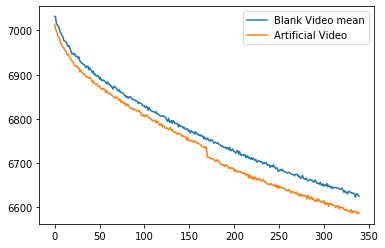

In [151]:
plt.plot(np.mean(blank_video,axis=(1,2)),label='Blank Video mean')
plt.plot(np.mean(artificial_video2,axis=(1,2)),label='Artificial Video')
plt.legend()

### Blank Video Subtraction (BkS)

In [152]:
corrected_signal_video = artificial_video2/np.mean(artificial_video2[:i2_5_sub-1],axis=0)
corrected_blank_video = blank_video/np.mean(blank_video[:i2_5_sub-1],axis=0)
BkS_video = (corrected_signal_video - corrected_blank_video)*np.mean(artificial_video2[:i2_5_sub-1],axis=0)
# BkS_video = -(artificial_video2 - blank_video)

In [153]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_BkS, time_artificial   = mes.segment(cell_mask, BkS_video, 1/time_sub[1])

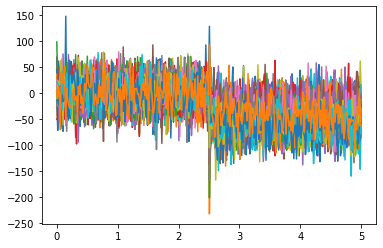

In [154]:
plt.plot(time_artificial,ROIs_means_BkS)

# Performance outputs

### Relative Peak Amplitude Error and Stationary Amplitude Error

In [155]:
BkS_meanbaseline = np.median(ROIs_means_BkS[0:i2_5_sub-3],axis=0)
print(BkS_meanbaseline)
BkS_no_offset = ROIs_means_BkS - BkS_meanbaseline

[-0.19 -1.76 -1.17 -0.07  0.21 -3.11 -0.88  0.4  -3.07 -0.07  2.29  2.4
 -1.11 -0.97 -1.13  0.72  1.37 -2.54 -2.3  -1.69  1.24  0.57  0.28  0.43
 -1.34 -0.44 -0.7  -1.53  0.57 -1.7  -1.42 -1.5 ]


In [156]:
BkS_max_values = BkS_no_offset[max_idx_sub]
print(BkS_max_values)

[ -27.96   44.72   26.13   10.77  -10.93  -49.61 -165.01  -96.89 -153.63
  -49.24   -7.93 -102.29  -40.56  -44.77   22.31   50.45   35.57   45.85
   32.03  -14.34  -81.89 -232.49 -201.46 -137.11  -44.06  -83.97 -102.59
 -164.61 -105.63   69.97  129.65   94.58]


In [157]:
BkS_median_values = np.median(BkS_no_offset[i2_5_sub+3:],axis=0)

In [158]:
Rel_error_max_BkS = ((BkS_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_BkS)

[-1.53e+02  3.19e+01 -1.47e+00 -2.10e+01 -6.47e+01 -4.44e+01  2.62e+01
 -1.37e+01  9.95e+01 -7.75e+00 -8.73e+01  3.13e+01 -4.18e+01  1.04e+02
 -6.24e+01 -3.44e+01 -3.10e+01 -1.87e+01 -4.71e+01 -1.47e+02  9.53e+00
  2.45e+01  1.07e+01  3.80e+00 -4.22e+01 -1.00e+01 -1.04e+01  2.50e+01
  1.12e-01  2.68e+01  1.09e+01  8.89e+00]


In [159]:
Rel_error_median_BkS = ((BkS_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_BkS)

[ -2.09 -10.24   4.58  -6.29  -6.69   1.76  -0.6   23.41 -10.58 -25.19
  20.86  12.56 -12.46  -2.36  11.94  12.92  -0.77 -12.75  -9.58  -0.3
   1.17  -0.34   6.97 -15.05 -15.07  14.87  -3.53   1.73   1.08 -10.3
   2.8    3.86]


### RMSE (Root-Mean-Squared Error)

In [163]:
RMSE_BkS = (np.sqrt(np.sum((BkS_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_BkS)

[29.3  26.06 29.18 27.78 31.07 31.08 30.3  27.69 28.56 24.55 27.03 26.18
 29.48 29.12 27.76 27.31 27.71 27.05 30.01 27.53 29.2  25.94 28.44 28.13
 26.73 27.54 25.01 27.58 26.42 25.9  25.   27.24]


# Blank Subtraction + detrending (BkSD)

In [166]:
from scipy import signal as sig
ROIs_means_BkSD = sig.detrend(ROIs_means_BkS,axis=0)

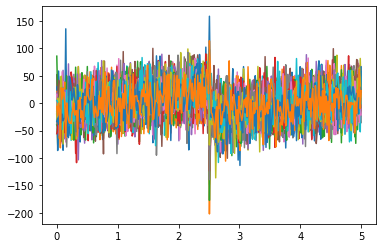

In [167]:
plt.plot(time_artificial,ROIs_means_BkSD)

# Performance outputs

### Relative Max Amplitude Error

In [168]:
BkSD_meanbaseline = np.median(ROIs_means_BkSD[0:i2_5_sub-3],axis=0)
print(BkSD_meanbaseline)
BkSD_no_offset = ROIs_means_BkSD - BkSD_meanbaseline

[ 2.17  3.3   3.94  5.75  6.29  5.21  8.57  3.23 -0.25  0.61  7.51  4.44
  6.39  3.99  5.34  3.05  4.4   2.02  7.73  9.28 11.87  6.97  9.01  1.88
  0.57  5.77  2.23  5.22  6.24  5.42  5.66  3.56]


In [169]:
BkSD_max_values = BkSD_no_offset[max_idx_sub]
print(BkSD_max_values)

[-2.01e+01  5.01e+01  3.94e+01  2.96e+01  1.57e+01 -2.47e+01 -1.49e+02
 -8.21e+01 -1.48e+02 -4.44e+01 -1.82e-01 -8.47e+01 -2.46e+01 -2.05e+01
  4.53e+01  6.69e+01  4.53e+01  6.16e+01  5.11e+01  1.23e+01 -5.56e+01
 -2.09e+02 -1.86e+02 -1.26e+02 -3.67e+01 -7.41e+01 -8.70e+01 -1.45e+02
 -8.24e+01  9.27e+01  1.53e+02  1.10e+02]


In [170]:
Rel_error_max_BkSD = ((BkSD_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_BkSD)

[-137.99   47.61   48.76  117.07 -150.9   -72.32   14.02  -26.91   91.77
  -16.86  -99.71    8.7   -64.72   -6.8   -23.66  -12.96  -12.11    9.27
  -15.61  -59.88  -25.64   11.83    2.34   -4.77  -51.91  -20.62  -24.01
    9.85  -21.86   67.97   30.83   26.91]


In [171]:
BkSD_median_values = np.median(BkSD_no_offset[i2_5_sub+3:],axis=0)

In [172]:
Rel_error_median_BkSD = ((BkSD_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_BkSD)

[-79.85 -53.18 -78.1  -75.96 -78.56 -75.85 -75.28 -64.75 -89.86 -87.02
 -50.16 -70.62 -78.91 -82.13 -74.87 -75.97 -70.32 -81.73 -80.26 -72.86
 -74.71 -81.5  -75.77 -78.83 -82.2  -59.91 -86.05 -79.54 -80.83 -77.4
 -84.39 -75.39]


### RMSE (Root-Mean-Squared Error)

In [177]:
RMSE_BkSD = (np.sqrt(np.sum((BkSD_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_BkSD)

[32.2  28.47 35.02 41.19 53.1  50.25 40.32 32.51 30.82 26.27 29.16 34.15
 41.83 45.97 40.94 34.61 31.2  37.47 45.94 50.05 49.59 43.1  36.81 33.81
 29.45 31.3  34.34 40.63 43.69 46.21 42.29 35.39]


# Averaging over 10 trials

In [179]:
def new_noise_vid(n,cell_mask,time_sub,var_img):
    # Generate noise video
    noise_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
    # Generate noise power image
    noise_power_img2 = np.zeros_like(var_img)
    for i in range(cell_mask.shape[0]):
        for j in range(cell_mask.shape[1]):
            #each pixel noise is independently generated
            np.random.seed((cell_mask.shape[1]*i) + j + n*(cell_mask.shape[0]*cell_mask.shape[1]))
            #each pixel noise comes from poisson distribution with std from respective experimental pixel data
            noise_vid2[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
            #calculates each pixel noise power
            noise_power_img2[i,j] = np.sum(np.square(abs(noise_vid2[:,i,j])),axis=0)/(noise_vid2.shape[0])
    return(noise_vid2,noise_power_img2)

In [180]:
avg_new_vid10_stack = np.zeros((10,artificial_video2.shape[0],artificial_video2.shape[1],artificial_video2.shape[2]),dtype='uint16')

In [181]:
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = True
Poisson_noise_switch = True

for i in range(10):
    new_vid = np.zeros_like(artificial_video2,dtype='float')
    noise_vid3, noise_power_img2 = new_noise_vid(i+1,cell_mask,time_sub,var_img)
    print(i)
    new_vid += photobleaching_drift_percent*Basal_fluorescence_switch*pure_basal_fluo_vid + photobleaching_drift_percent*Photobleaching_switch*photob_vid + \
                Signal_switch*signal_vid2 + Poisson_noise_switch*noise_vid3
    new_vid = np.around(new_vid).astype('uint16')
    
    avg_new_vid10_stack[i] = new_vid
avg_new_vid10 = np.mean(avg_new_vid10_stack,axis=0)
del avg_new_vid10_stack

0
1
2
3
4
5
6
7
8
9


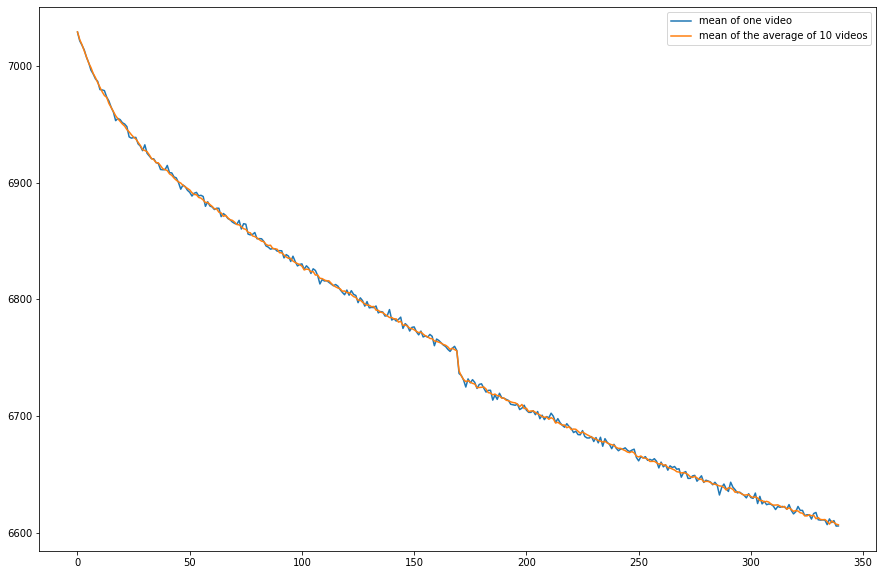

In [183]:
plt.figure(figsize=[15,10])
plt.plot(np.mean(new_vid,axis=(1,2)),label='mean of one video')
plt.plot(np.mean(avg_new_vid10,axis=(1,2)),label='mean of the average of 10 videos')
plt.legend()

In [184]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_avg10, time_artificial   = mes.segment(cell_mask, avg_new_vid10, 1/time_sub[1])
import Remove_Photobleaching as rpb
transitory = False
t_sig_onset = 2.5
t_sig_end = None
ROIs_means_avg10_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(avg_new_vid10,time_sub, cell_mask,ROIs_means_avg10,transitory,t_sig_onset,t_sig_end)

# Performance outputs

### Check Noise reduction and SNR increase

In [187]:
N_avg10 = np.zeros_like(N)
active_mask = np.zeros_like(time_sub,dtype=bool)
active_mask[i2_5_sub:] = True
inactive_mask = np.invert(active_mask)

for i in range(len(N)):
    N_avg10[i] = np.sum(np.square(abs(ROIs_means_avg10_corrected[inactive_mask,i])),axis=0)/(ROIs_means_avg10_corrected[inactive_mask,:].shape[0])

In [188]:
SNR_avg10 = P2/N_avg10
print(np.mean(SNR_avg10/SNR))

9.502145462670391


### Relative Max Amplitude Error

In [189]:
avg10_meanbaseline = np.median(ROIs_means_avg10_corrected[0:i2_5_sub-3],axis=0)
print(avg10_meanbaseline)
avg10_no_offset = ROIs_means_avg10_corrected - avg10_meanbaseline

[-0.44 -0.52 -0.29  0.41  0.12 -0.81 -0.33 -0.06  0.29  0.02  0.16 -0.29
 -0.02  0.18  0.46  0.04  0.57 -0.31 -0.11 -0.33 -0.72 -0.67  0.07 -0.11
 -0.08 -0.24 -0.35 -0.07  0.2   0.02  0.29  0.14]


In [190]:
avg10_max_values = avg10_no_offset[max_idx_sub]
print(avg10_max_values)

[  46.14   30.11   29.95    8.52  -39.95  -95.41 -142.58 -119.84  -87.53
  -65.92  -69.11  -87.81  -88.64  -17.57   53.63   64.01   44.38   73.41
   66.95   30.65  -73.76 -189.83 -187.47 -137.98  -78.86  -94.74 -109.35
 -132.25 -116.81   44.37  106.23   82.44]


In [191]:
Rel_error_max_avg10 = ((avg10_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_avg10)

[-12.8  -11.23  12.93 -37.44  29.16   6.93   9.03   6.68  13.7   23.49
  11.07  12.7   27.19 -19.98  -9.57 -16.71 -13.94  30.23  10.64   0.28
  -1.35   1.62   2.99   4.46   3.44   1.5   -4.49   0.45  10.71 -19.62
  -9.14  -5.09]


In [192]:
avg10_median_values = np.median(avg10_no_offset[i2_5_sub+3:],axis=0)

In [193]:
Rel_error_median_avg10 = ((avg10_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_avg10)

[22.08 41.79 13.78 20.67  8.94 15.08 22.8  37.58 50.52 66.21 40.46 21.09
 23.48  9.21 20.34 18.05 40.14 13.42 11.43 10.08 11.11 21.23 26.76 36.43
 53.04 43.66 29.56 18.44 21.33 12.52 15.12 15.41]


### RMSE (Root-Mean-Squared Error)

In [198]:
RMSE_avg10 = (np.sqrt(np.sum((avg10_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_avg10)

[ 7.87  8.79  7.95 10.02  8.53  9.69 11.   10.38  9.68  9.83 10.11  9.07
 11.46  7.81  9.92  8.74 10.02  8.31  8.1   8.61  9.22 11.18 11.15 10.15
 10.12 11.15 10.09  9.13 10.72  8.58  9.04  7.95]


# Averaging over n trials

In [200]:
def new_noise_vid(n,cell_mask,time_sub,var_img):
    # Generate noise video
    noise_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
    # Generate noise power image
    noise_power_img2 = np.zeros_like(var_img)
    for i in range(cell_mask.shape[0]):
        for j in range(cell_mask.shape[1]):
            #each pixel noise is independently generated
            np.random.seed((cell_mask.shape[1]*i) + j + n*(cell_mask.shape[0]*cell_mask.shape[1]))
            #each pixel noise comes from poisson distribution with std from respective experimental pixel data
            noise_vid2[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
            #calculates each pixel noise power
            noise_power_img2[i,j] = np.sum(np.square(abs(noise_vid2[:,i,j])),axis=0)/(noise_vid2.shape[0])
    return(noise_vid2,noise_power_img2)

In [201]:
avg_new_vid400_stack = np.zeros((400,artificial_video2.shape[0],artificial_video2.shape[1],artificial_video2.shape[2]),dtype='uint16')

In [202]:
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = True
Poisson_noise_switch = True

for i in range(400):
    new_vid = np.zeros_like(artificial_video2,dtype='float')
    noise_vid3, noise_power_img2 = new_noise_vid(i+1,cell_mask,time_sub,var_img)
    print(i)
    new_vid += photobleaching_drift_percent*Basal_fluorescence_switch*pure_basal_fluo_vid + photobleaching_drift_percent*Photobleaching_switch*photob_vid + \
                Signal_switch*signal_vid2 + Poisson_noise_switch*noise_vid3
    new_vid = np.around(new_vid).astype('uint16')
    
    avg_new_vid400_stack[i] = new_vid
avg_new_vids = np.mean(avg_new_vid400_stack,axis=0)
del avg_new_vid400_stack

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [203]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_avgn, time_artificial   = mes.segment(cell_mask, avg_new_vids, 1/time_sub[1])
import Remove_Photobleaching as rpb
transitory = False
t_sig_onset = 2.5
t_sig_end = None
ROIs_means_avgn_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(avg_new_vids,time_sub, cell_mask,ROIs_means_avgn,transitory,t_sig_onset,t_sig_end)

# Performance outputs

### Check Noise reduction and SNR increase

In [204]:
N_avg400 = np.zeros_like(N)
active_mask = np.zeros_like(time_sub,dtype=bool)
active_mask[i2_5_sub:] = True
inactive_mask = np.invert(active_mask)

for i in range(len(N)):
    N_avg400[i] = np.sum(np.square(abs(ROIs_means_avgn_corrected[inactive_mask,i])),axis=0)/(ROIs_means_avgn_corrected[inactive_mask,:].shape[0])

In [205]:
SNR_avg400 = P2/N_avg400
print(np.mean(SNR_avg10/SNR))
print(np.mean(SNR_avg400/SNR))

9.502145462670391
30.301148916904992


### Relative Max Amplitude Error

In [206]:
avgn_meanbaseline = np.median(ROIs_means_avgn_corrected[0:i2_5_sub-3],axis=0)
print(avgn_meanbaseline)
avgn_no_offset = ROIs_means_avgn_corrected - avgn_meanbaseline

[0.54 0.1  0.21 0.16 0.49 0.75 0.61 0.24 0.41 0.11 0.27 0.28 0.22 0.43
 0.09 0.26 0.07 0.3  0.05 0.23 0.56 0.68 0.17 0.47 0.35 0.32 0.37 0.22
 0.33 0.16 0.43 0.08]


In [207]:
avgn_max_values = avgn_no_offset[max_idx_sub]
print(avgn_max_values)

[  48.26   28.48   20.21    8.88  -36.8   -97.09 -139.63 -119.77  -82.65
  -58.6   -66.98  -82.15  -77.64  -28.48   54.06   72.21   46.63   52.48
   56.22   25.21  -81.   -194.17 -188.25 -139.9   -83.5   -99.99 -120.55
 -139.58 -113.08   49.84  112.77   82.61]


In [208]:
Rel_error_max_avgn = ((avgn_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_avgn)

[ -8.78 -16.02 -23.77 -34.8   18.98   8.8    6.78   6.62   7.35   9.79
   7.63   5.44  11.4   29.68  -8.84  -6.03  -9.59  -6.91  -7.1  -17.51
   8.33   3.94   3.42   5.92   9.53   7.13   5.29   6.02   7.18  -9.7
  -3.55  -4.89]


In [209]:
avgn_median_values = np.median(avgn_no_offset[i2_5_sub+3:],axis=0)

In [210]:
Rel_error_median_avgn = ((avgn_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_avgn)

[34.29 38.54 24.12 17.15 13.73 18.49 26.75 38.76 61.5  62.92 43.3  28.07
 21.1  17.15 14.76 20.19 26.11 19.57 12.42 11.87 14.75 24.76 30.62 41.76
 58.15 40.14 33.03 24.7  20.37 12.4  12.41 19.28]


### RMSE (Root-Mean-Squared Error)

In [215]:
RMSE_avgn = (np.sqrt(np.sum((avgn_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_avgn)

[ 6.02  6.25  6.31  6.8   7.54  8.88  9.61  8.53  8.11  7.31  7.73  8.05
  8.42  7.53  6.04  5.73  5.59  6.41  5.86  6.54  8.05 10.55  9.74  9.32
  8.27  8.33  9.03  9.16  8.87  6.23  5.79  5.75]


# Extracted outputs with METROID

In [220]:
import sys,os
if metroidpath not in sys.path:
    sys.path.append(metroidpath)
import METROID as metroid

path = "./Output_EP_video"
fr = [fs]
transitory = False
stack_ROIs_EP, label_ROIs_EP, ROIs_means_filtered_EP_default, time_EP, \
ROIs_means_EP, ROIs_means_corrected_EP,  \
mask_list_EP, components_EP, selected_source_idx_EP, \
t_sig_prop_EP, SNR_dB_EP = metroid.metroid(path, fr, transitory)

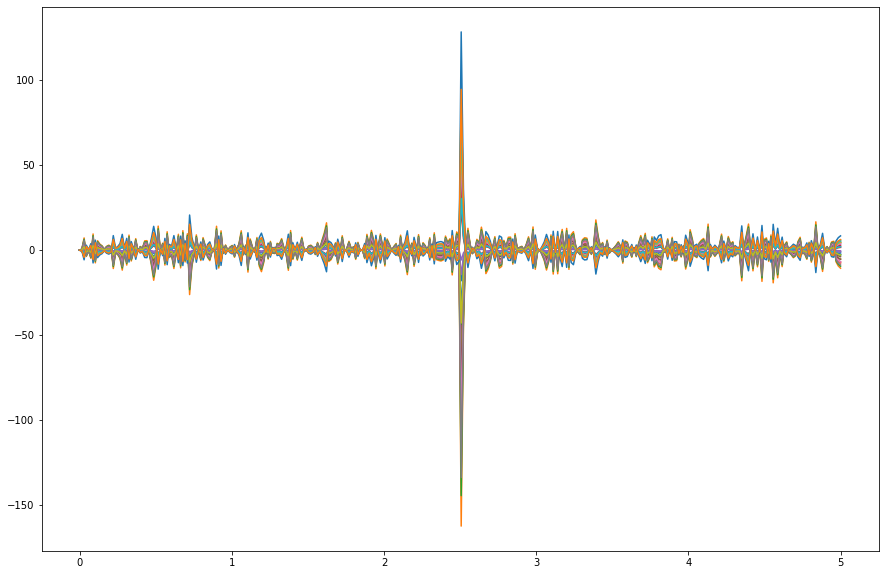

In [221]:
plt.figure(figsize=[15,10])
plt.plot(time_EP,ROIs_means_filtered_EP_default)

# Performance outputs

### Relative Max Amplitude Error

In [222]:
metroid_default_meanbaseline = np.median(ROIs_means_filtered_EP_default[0:i2_5_sub-3],axis=0)
print(metroid_default_meanbaseline)
metroid_default_no_offset = ROIs_means_filtered_EP_default - metroid_default_meanbaseline

[-0.01 -0.02 -0.02 -0.01  0.    0.01  0.03  0.02  0.02  0.01  0.    0.03
  0.01 -0.01 -0.01 -0.02 -0.01 -0.02 -0.02 -0.01  0.01  0.04  0.04  0.03
  0.    0.02  0.03  0.03  0.01 -0.02 -0.03 -0.02]


In [223]:
metroid_default_max_values = metroid_default_no_offset[max_idx_sub]
print(metroid_default_max_values)

[  32.13   64.92   91.43   44.27   -5.81  -58.96 -121.45  -82.46  -80.07
  -42.29  -18.06 -113.99  -43.6    24.62   55.8    70.22   59.8    75.48
   71.4    30.49  -34.49 -162.66 -144.71 -106.72  -14.43  -81.59 -106.05
 -134.01  -42.96   83.15  128.65   94.78]


In [224]:
Rel_error_max_metroid_default = ((metroid_default_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_metroid_default)

[-3.93e+01  9.14e+01  2.45e+02  2.25e+02 -8.12e+01 -3.39e+01 -7.12e+00
 -2.66e+01  4.00e+00 -2.08e+01 -7.10e+01  4.63e+01 -3.74e+01 -2.12e+02
 -5.91e+00 -8.63e+00  1.60e+01  3.39e+01  1.80e+01 -2.39e-01 -5.39e+01
 -1.29e+01 -2.05e+01 -1.92e+01 -8.11e+01 -1.26e+01 -7.37e+00  1.79e+00
 -5.93e+01  5.06e+01  1.00e+01  9.12e+00]


In [225]:
metroid_default_median_values = np.mean(metroid_default_no_offset[i2_5_sub+3:],axis=0)

In [226]:
Rel_error_median_metroid_default = ((metroid_default_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_metroid_default)

[ -99.9   -99.79  -99.82  -99.94 -100.01 -100.06 -100.17 -100.19 -100.31
 -100.19 -100.05 -100.2  -100.06  -99.97  -99.93  -99.87  -99.85  -99.88
  -99.92  -99.97 -100.03 -100.19 -100.22 -100.24 -100.05 -100.2  -100.19
 -100.18 -100.05  -99.91  -99.85  -99.83]


### RMSE (Root-Mean-Squared Error)

In [231]:
RMSE_metroid_default = (np.sqrt(np.sum((metroid_default_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_metroid_default)

[16.22 15.37 24.44 37.16 51.04 46.27 34.86 21.2  13.01 11.15 17.16 27.38
 36.82 41.21 36.77 25.62 18.95 29.85 43.55 51.76 51.59 42.32 31.92 22.18
 14.17 20.26 27.1  36.08 41.96 45.62 41.58 27.54]


# Extracted outputs with METROID (PCA optimized parameters)

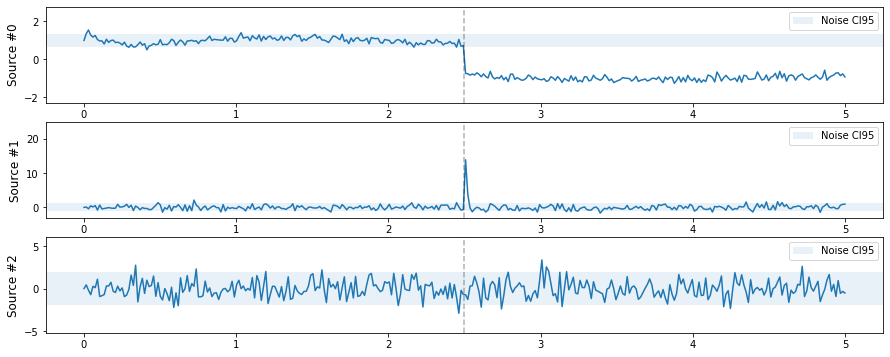

Enter one or more sources number (separate numbers by "," if number of sources > 1): 0,1


In [233]:
transitory = False
t_sig_onset = 2.5
t_sig_end = None
n_comp = 3
wavelet = 'Haar'
method = 'PCA'
autoselect = 'manual'

stack_ROIs_EP, label_ROIs_EP, ROIs_means_filtered_EP_optimized, time_EP, \
ROIs_means_EP, ROIs_means_corrected_EP, \
mask_list_EP, components_EP, selected_source_idx_EP, \
t_sig_prop_EP, SNR_dB_EP = metroid.metroid(path, fr, transitory,16,16, t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect)

In [234]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial1, time_artificial   = mes.segment(cell_mask, artificial_video, fs)

In [235]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial11, time_artificial   = mes.segment(cell_mask, artificial_video2, fs)
transitory = False
t_sig_onset = 2.5
t_sig_end = None
ROIs_means_artificial11_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(artificial_video2,time_sub, cell_mask,ROIs_means_artificial11,transitory,t_sig_onset,t_sig_end)


# Performance outputs

### Relative Max Amplitude Error

In [236]:
metroid_optimized_meanbaseline = np.median(ROIs_means_filtered_EP_optimized[0:i2_5_sub-3],axis=0)
print(metroid_optimized_meanbaseline)
metroid_optimized_no_offset = ROIs_means_filtered_EP_optimized - metroid_optimized_meanbaseline

[-0.03 -0.02 -0.01 -0.3  -0.22 -0.09 -0.19 -0.09 -0.13 -0.09 -0.09 -0.18
 -0.07 -0.1  -0.25 -0.02 -0.05 -0.05 -0.27 -0.07 -0.17 -0.13 -0.02 -0.17
 -0.05 -0.11 -0.03 -0.2  -0.06 -0.07 -0.04 -0.  ]


In [237]:
metroid_optimized_max_values = metroid_optimized_no_offset[max_idx_sub]
print(metroid_optimized_max_values)

[  20.     47.46   69.16   10.51  -50.18 -105.66 -152.75 -111.9   -99.9
  -55.24  -39.1  -143.96  -79.39  -11.19   15.25   45.17   41.58   51.64
   33.73  -17.61  -91.99 -205.81 -177.69 -126.82  -33.24 -109.19 -133.18
 -167.81  -83.58   46.62   90.53   69.77]


In [238]:
Rel_error_max_metroid_optimized = ((metroid_optimized_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_metroid_optimized)

[ -62.19   39.93  160.8   -22.81   62.25   18.41   16.81   -0.39   29.75
    3.48  -37.16   84.76   13.91  -49.07  -74.29  -41.22  -19.37   -8.4
  -44.25 -157.62   23.03   10.18   -2.38   -3.99  -56.4    16.98   16.33
   27.46  -20.79  -15.54  -22.56  -19.68]


In [239]:
metroid_optimized_median_values = np.median(metroid_optimized_no_offset[i2_5_sub+3:],axis=0)

In [240]:
Rel_error_median_metroid_optimized = ((metroid_optimized_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_metroid_optimized)

[-2.22 38.7  21.13 11.39  8.29 22.16  9.45 69.93 97.3  46.47 55.83 32.36
 13.06  5.38 30.45 23.54 19.14  2.26  7.11 12.2  35.25 19.91 32.8  18.28
 71.58 65.92 17.6  16.18 16.39 -3.   10.18  9.56]


### RMSE (Root-Mean-Squared Error)

In [245]:
RMSE_metroid_optimized = (np.sqrt(np.sum((metroid_optimized_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_metroid_optimized)

[ 3.13  6.89  7.78  6.64  7.39 12.03  7.19 15.32 12.91  5.65  9.77 11.15
  6.74  5.58 12.68  7.8   5.21  5.3   7.24  9.51 19.33 11.87 12.48  6.43
 10.23 14.06  7.24  9.22  8.8   7.04  9.22  6.34]


# Extracted outputs with METROID (wPCA optimized parameters)

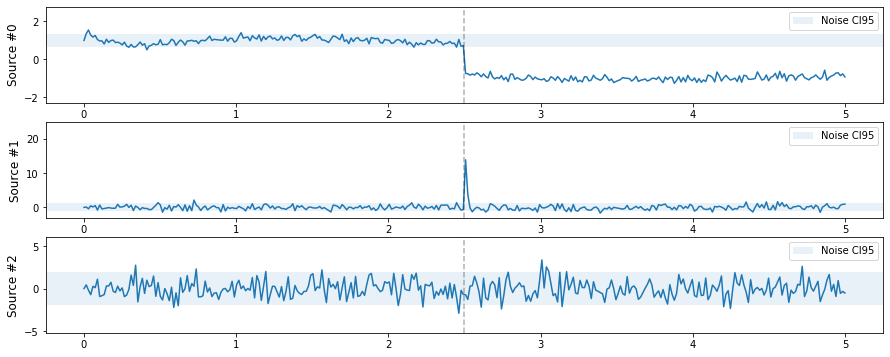

Enter one or more sources number (separate numbers by "," if number of sources > 1): 0,1


In [247]:
transitory = False
t_sig_onset = 2.5
t_sig_end = None
n_comp = 3
wavelet = 'Haar'
method = 'wPCA'
autoselect = 'manual'

stack_ROIs_EP, label_ROIs_EP, ROIs_means_filtered_EP_optimized2, time_EP, \
ROIs_means_EP, ROIs_means_corrected_EP, \
mask_list_EP, components_EP, selected_source_idx_EP, \
t_sig_prop_EP, SNR_dB_EP = metroid.metroid(path, fr, transitory,16,16, t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect)

In [248]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial1, time_artificial   = mes.segment(cell_mask, artificial_video, fs)

In [249]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial11, time_artificial   = mes.segment(cell_mask, artificial_video2, fs)
transitory = False
t_sig_onset = 2.5
t_sig_end = None
ROIs_means_artificial11_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(artificial_video2,time_sub, cell_mask,ROIs_means_artificial11,transitory,t_sig_onset,t_sig_end)


(array([-80., -60., -40., -20.,   0.,  20.,  40.,  60.,  80.]),
 <a list of 9 Text yticklabel objects>)

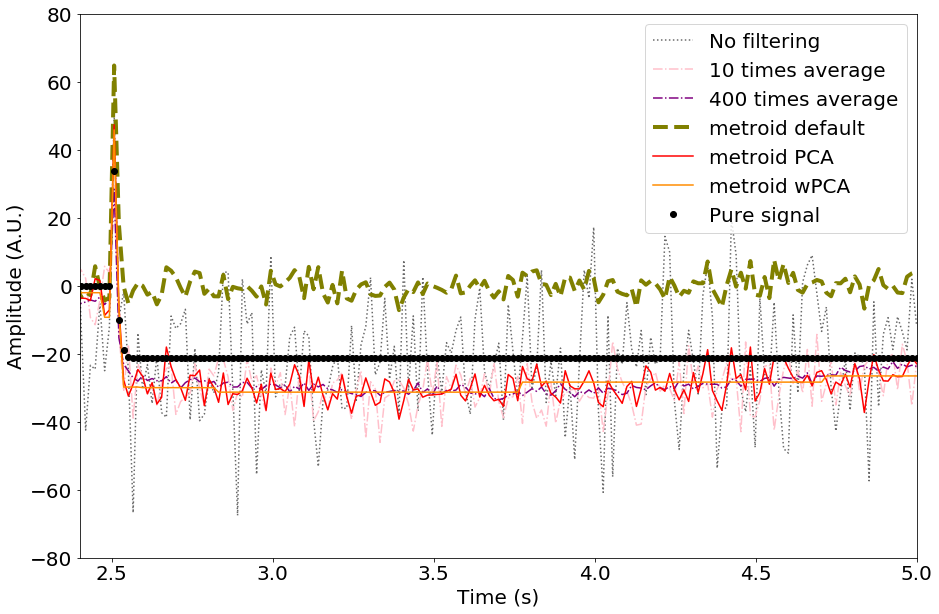

In [251]:
i = 1
plt.figure(figsize=[15,10])
plt.plot(time_EP,ROIs_means_artificial1[:,i] - np.median(ROIs_means_artificial1[0:i2_5_sub-3,i]),':',color='dimgray',label='No filtering')
plt.plot(time_EP,avg10_no_offset[:,i],'-.',label='10 times average',color='pink')
plt.plot(time_EP,avgn_no_offset[:,i],'-.',label='400 times average',color='purple')

plt.plot(time_EP,ROIs_means_filtered_EP_default[:,i],'--',label='metroid default',lw=4,color='olive')
plt.plot(time_EP,ROIs_means_filtered_EP_optimized[:,i],'r-',label='metroid PCA')
plt.plot(time_EP,ROIs_means_filtered_EP_optimized2[:,i],color='darkorange',label='metroid wPCA')
plt.plot(time_EP,ROIs_means_signal2[:,i],'ko',label='Pure signal')
plt.legend(fontsize=20)
plt.axis([2.4,5,-80,80])
plt.xlabel('Time (s)',size=20)
plt.ylabel('Amplitude (A.U.)',size=20)
plt.xticks(size=20)
plt.yticks(size=20)

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80.]),
 <a list of 8 Text yticklabel objects>)

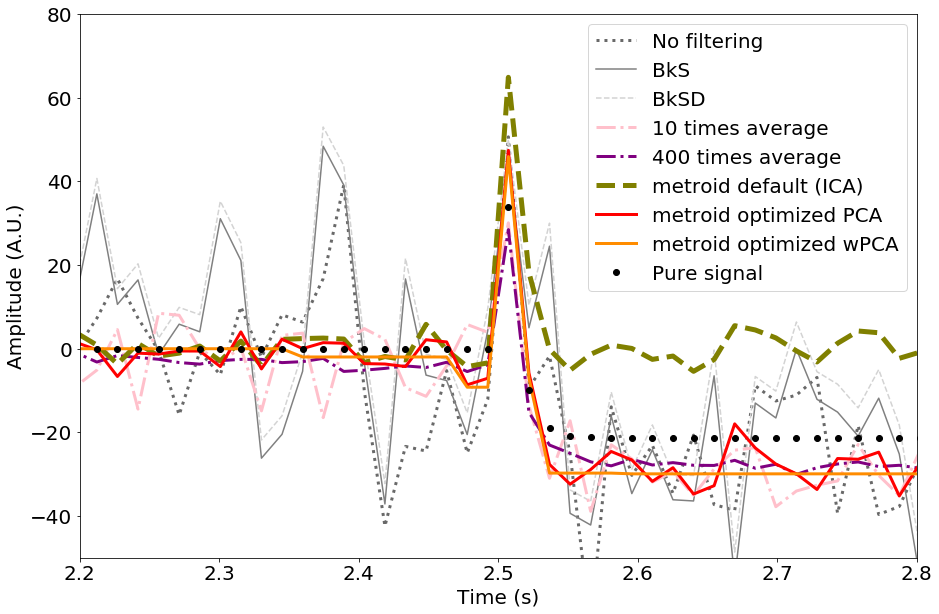

In [252]:
i = 1
plt.figure(figsize=[15,10])
plt.plot(time_EP,ROIs_means_artificial1[:,i] - np.median(ROIs_means_artificial1[0:i2_5_sub-3,i]),':',color='dimgray',label='No filtering',lw=3)
plt.plot(time_EP,BkS_no_offset[:,i],label='BkS',color='gray')
plt.plot(time_EP,BkSD_no_offset[:,i],'--',label='BkSD',color='lightgray')

plt.plot(time_EP,avg10_no_offset[:,i],'-.',label='10 times average',color='pink',lw=3)
plt.plot(time_EP,avgn_no_offset[:,i],'-.',label='400 times average',color='purple',lw=3)

plt.plot(time_EP,ROIs_means_filtered_EP_default[:,i],'--',label='metroid default (ICA)',lw=5,color='olive')
plt.plot(time_EP,ROIs_means_filtered_EP_optimized[:,i],'r-',label='metroid optimized PCA',lw=3)
plt.plot(time_EP,ROIs_means_filtered_EP_optimized2[:,i],color='darkorange',label='metroid optimized wPCA',lw=3)
plt.plot(time_EP,ROIs_means_signal2[:,i],'ko',label='Pure signal')
plt.legend(fontsize=20)
plt.axis([2.2,2.8,-50,80])
plt.xlabel('Time (s)',size=20)
plt.ylabel('Amplitude (A.U.)',size=20)
plt.xticks(size=20)
plt.yticks(size=20)

# Performance outputs

### Relative Max Amplitude Error

In [253]:
metroid_optimized2_meanbaseline = np.median(ROIs_means_filtered_EP_optimized2[0:i2_5_sub-3],axis=0)
print(metroid_optimized2_meanbaseline)
metroid_optimized2_no_offset = ROIs_means_filtered_EP_optimized2 - metroid_optimized2_meanbaseline

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [254]:
metroid_optimized2_max_values = metroid_optimized2_no_offset[max_idx_sub]
print(metroid_optimized2_max_values)

[  19.41   45.95   67.05   10.12  -48.52 -102.84 -149.28 -108.83  -97.63
  -53.83  -38.   -140.68  -77.26  -10.96   14.68   43.86   40.21   49.93
   32.4   -17.26  -89.22 -201.03 -173.5  -124.3   -32.26 -106.39 -130.04
 -163.98  -81.32   45.12   87.79   67.6 ]


In [255]:
Rel_error_max_metroid_optimized2 = ((metroid_optimized2_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_max_metroid_optimized2)

[ -63.32   35.48  152.86  -25.7    56.87   15.24   14.15   -3.12   26.81
    0.86  -38.94   80.56   10.86  -50.12  -75.25  -42.93  -22.02  -11.43
  -46.46 -156.48   19.32    7.62   -4.68   -5.9   -57.68   13.98   13.58
   24.55  -22.93  -18.26  -24.91  -22.18]


In [256]:
metroid_optimized2_median_values = np.median(metroid_optimized2_no_offset[i2_5_sub+3:],axis=0)

In [257]:
Rel_error_median_metroid_optimized2 = ((metroid_optimized2_median_values-true_median_values)/true_median_values)*100 
print(Rel_error_median_metroid_optimized2)

[-6.65 32.77 15.8   7.11  4.1  19.01  5.21 63.8  89.74 41.67 50.55 27.26
 10.15  1.52 25.37 17.92 14.15 -1.83  2.87  8.24 30.45 14.94 26.73 13.23
 65.64 60.8  12.25 11.66 13.3  -7.31  5.32  4.82]


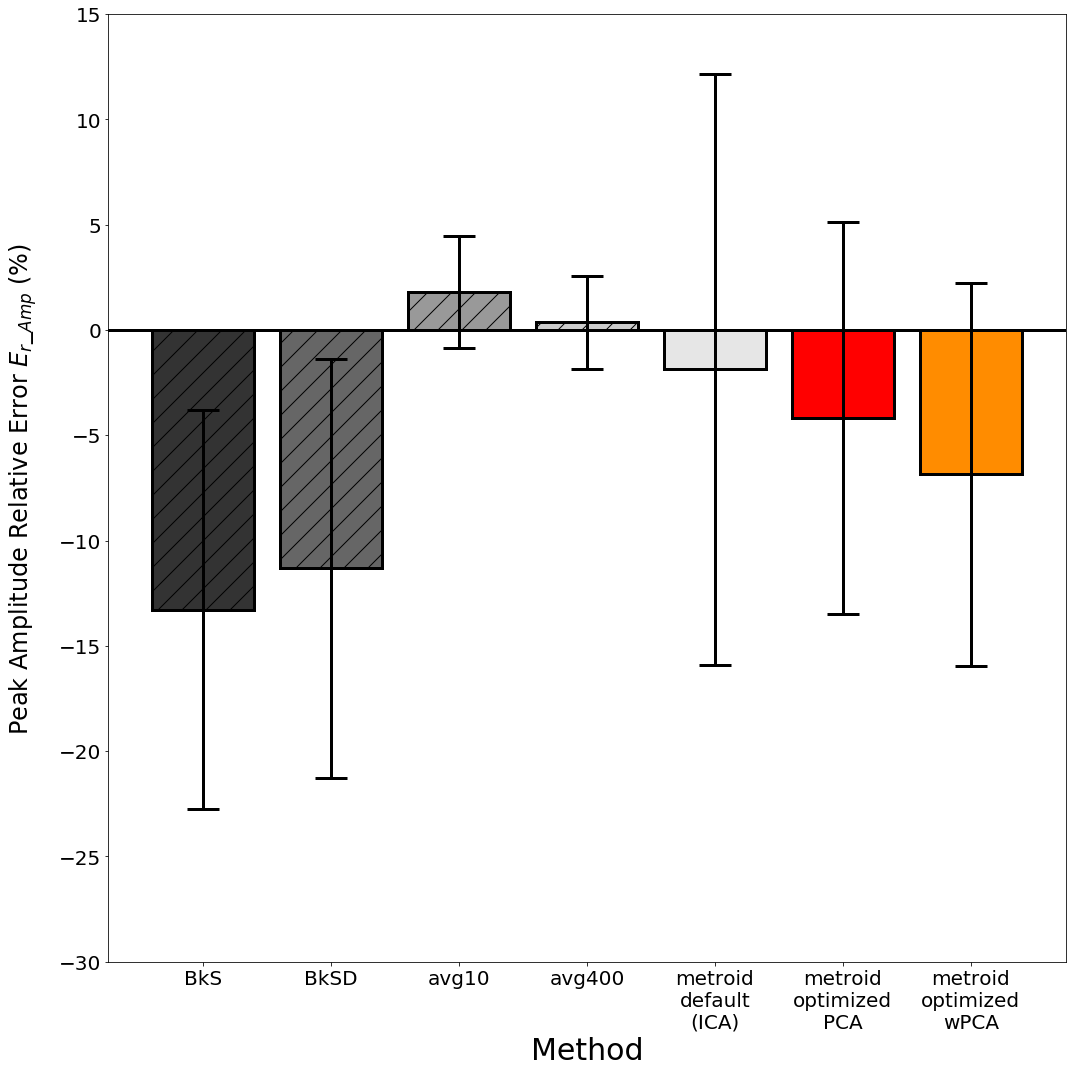

In [259]:
fig, ax = plt.subplots(figsize=[15,15])

graylvl=0.2
ax.bar(['BkS'],np.mean(Rel_error_max_BkS),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkS'],np.mean(Rel_error_max_BkS),np.std(Rel_error_max_BkS)/np.sqrt(len(Rel_error_max_BkS)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.4
ax.bar(['BkSD'],np.mean(Rel_error_max_BkSD),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkSD'],np.mean(Rel_error_max_BkSD),np.std(Rel_error_max_BkSD)/np.sqrt(len(Rel_error_max_BkSD)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.6
ax.bar(['avg10'],np.mean(Rel_error_max_avg10),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg10'],np.mean(Rel_error_max_avg10),np.std(Rel_error_max_avg10)/np.sqrt(len(Rel_error_max_avg10)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.8
ax.bar(['avg400'],np.mean(Rel_error_max_avgn),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg400'],np.mean(Rel_error_max_avgn),np.std(Rel_error_max_avgn)/np.sqrt(len(Rel_error_max_avgn)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.9
ax.bar(['metroid\ndefault\n(ICA)'],np.mean(Rel_error_max_metroid_default),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3)
ax.errorbar(['metroid\ndefault\n(ICA)'],np.mean(Rel_error_max_metroid_default),np.std(Rel_error_max_metroid_default)/np.sqrt(len(Rel_error_max_metroid_default)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nPCA'],np.mean(Rel_error_max_metroid_optimized),color='r',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nPCA'],np.mean(Rel_error_max_metroid_optimized),np.std(Rel_error_max_metroid_optimized)/np.sqrt(len(Rel_error_max_metroid_optimized)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nwPCA'],np.mean(Rel_error_max_metroid_optimized2),color='darkorange',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nwPCA'],np.mean(Rel_error_max_metroid_optimized2),np.std(Rel_error_max_metroid_optimized2)/np.sqrt(len(Rel_error_max_metroid_optimized2)),capsize=16,color='k',lw=3,capthick=3)

ax.set_yticks(np.arange(-30,30,5))
ax.set_ylim(-30, 15)  # most of the data

# Axes labels
s = 'Peak Amplitude Relative Error '+r'$E_r\__{Amp}$'+' (%)'
ax.set_ylabel(s,labelpad=20,size=24)
ax.set_xlabel('Method',size=30)

ax.tick_params('y',labelsize=20) #adjust yticks fontsize
ax.tick_params('x',labelsize=20)

plt.tight_layout()
ax.axhline(0,lw=3,color='k')

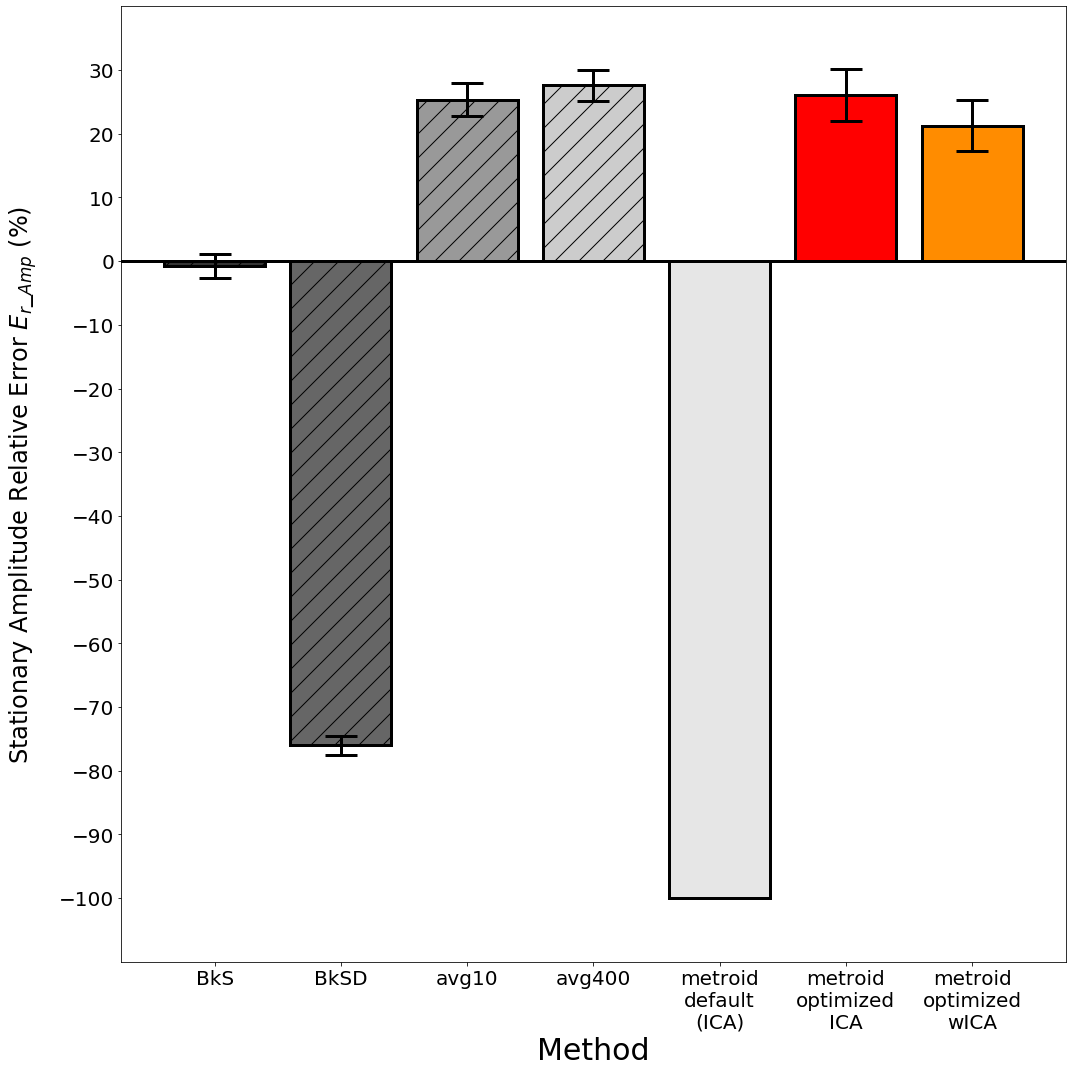

In [261]:
fig, ax = plt.subplots(figsize=[15,15])

graylvl=0.2
ax.bar(['BkS'],np.mean(Rel_error_median_BkS),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkS'],np.mean(Rel_error_median_BkS),np.std(Rel_error_median_BkS)/np.sqrt(len(Rel_error_median_BkS)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.4
ax.bar(['BkSD'],np.mean(Rel_error_median_BkSD),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkSD'],np.mean(Rel_error_median_BkSD),np.std(Rel_error_median_BkSD)/np.sqrt(len(Rel_error_median_BkSD)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.6
ax.bar(['avg10'],np.mean(Rel_error_median_avg10),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg10'],np.mean(Rel_error_median_avg10),np.std(Rel_error_median_avg10)/np.sqrt(len(Rel_error_median_avg10)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.8
ax.bar(['avg400'],np.mean(Rel_error_median_avgn),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg400'],np.mean(Rel_error_median_avgn),np.std(Rel_error_median_avgn)/np.sqrt(len(Rel_error_median_avgn)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.9
ax.bar(['metroid\ndefault\n(ICA)'],np.mean(Rel_error_median_metroid_default),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3)
ax.errorbar(['metroid\ndefault\n(ICA)'],np.mean(Rel_error_median_metroid_default),np.std(Rel_error_median_metroid_default)/np.sqrt(len(Rel_error_median_metroid_default)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nICA'],np.mean(Rel_error_median_metroid_optimized),color='r',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nICA'],np.mean(Rel_error_median_metroid_optimized),np.std(Rel_error_median_metroid_optimized)/np.sqrt(len(Rel_error_median_metroid_optimized)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nwICA'],np.mean(Rel_error_median_metroid_optimized2),color='darkorange',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nwICA'],np.mean(Rel_error_median_metroid_optimized2),np.std(Rel_error_median_metroid_optimized2)/np.sqrt(len(Rel_error_median_metroid_optimized2)),capsize=16,color='k',lw=3,capthick=3)

ax.set_yticks(np.arange(-100,35,10))
ax.set_ylim(-110, 40)  # most of the data

# Axes labels
s = 'Stationary Amplitude Relative Error '+r'$E_r\__{Amp}$'+' (%)'
ax.set_ylabel(s,labelpad=20,size=24)
ax.set_xlabel('Method',size=30)

ax.tick_params('y',labelsize=20) #adjust yticks fontsize
ax.tick_params('x',labelsize=20)

plt.tight_layout()
ax.axhline(0,lw=3,color='k')

### RMSE (Root-Mean-Squared Error)

In [263]:
RMSE_metroid_optimized2 = (np.sqrt(np.sum((metroid_optimized2_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_metroid_optimized2)

[ 2.32  6.04  6.02  4.49  4.73  9.21  3.82 13.14 11.41  4.6   8.69  8.58
  4.54  3.43 10.94  6.29  3.96  2.68  4.49  6.92 16.23  7.53  9.07  3.88
  9.31 12.06  4.34  5.68  6.42  4.26  5.74  3.86]


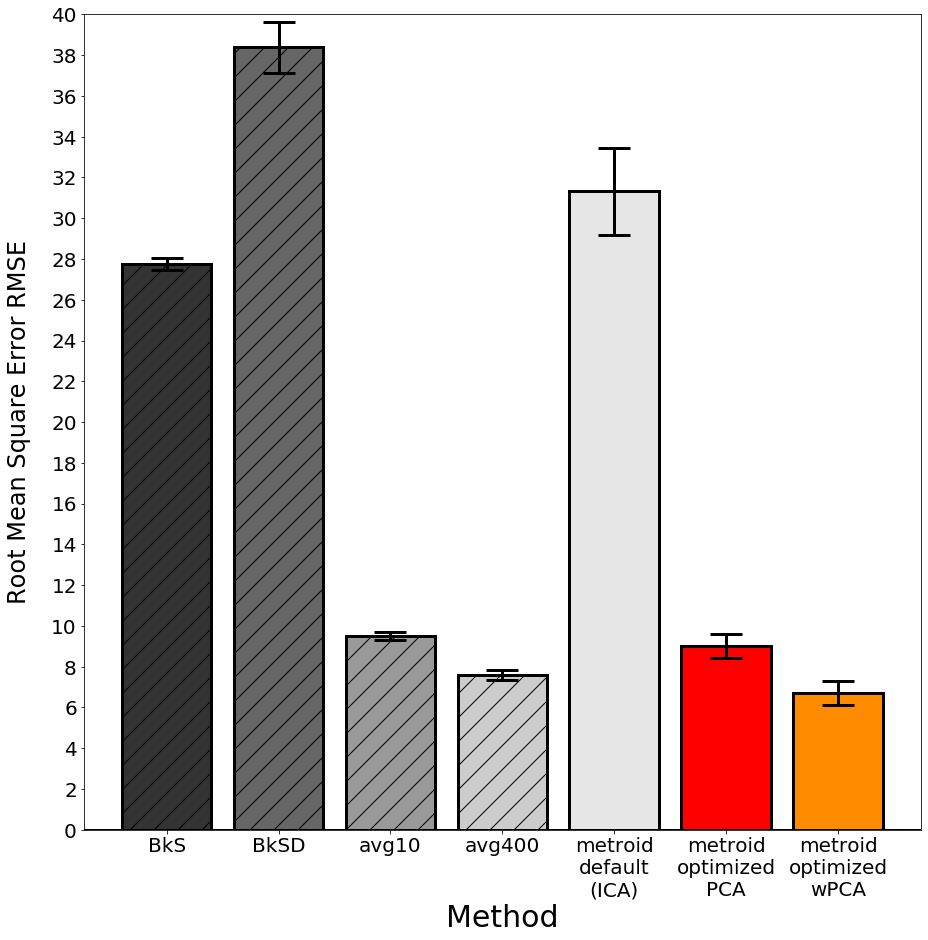

In [265]:
fig, ax = plt.subplots(figsize=[15,15])

graylvl=0.2
ax.bar(['BkS'],np.mean(RMSE_BkS),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkS'],np.mean(RMSE_BkS),np.std(RMSE_BkS)/np.sqrt(len(RMSE_BkS)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.4
ax.bar(['BkSD'],np.mean(RMSE_BkSD),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkSD'],np.mean(RMSE_BkSD),np.std(RMSE_BkSD)/np.sqrt(len(RMSE_BkSD)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.6
ax.bar(['avg10'],np.mean(RMSE_avg10),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg10'],np.mean(RMSE_avg10),np.std(RMSE_avg10)/np.sqrt(len(RMSE_avg10)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.8
ax.bar(['avg400'],np.mean(RMSE_avgn),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg400'],np.mean(RMSE_avgn),np.std(RMSE_avgn)/np.sqrt(len(RMSE_avgn)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.9
ax.bar(['metroid\ndefault\n(ICA)'],np.mean(RMSE_metroid_default),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3)
ax.errorbar(['metroid\ndefault\n(ICA)'],np.mean(RMSE_metroid_default),np.std(RMSE_metroid_default)/np.sqrt(len(RMSE_metroid_default)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nPCA'],np.mean(RMSE_metroid_optimized),color='r',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nPCA'],np.mean(RMSE_metroid_optimized),np.std(RMSE_metroid_optimized)/np.sqrt(len(RMSE_metroid_optimized)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nwPCA'],np.mean(RMSE_metroid_optimized2),color='darkorange',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nwPCA'],np.mean(RMSE_metroid_optimized2),np.std(RMSE_metroid_optimized2)/np.sqrt(len(RMSE_metroid_optimized2)),capsize=16,color='k',lw=3,capthick=3)

ax.set_yticks(np.arange(0,41,2))
ax.set_ylim(0, 40)  # most of the data

# Axes labels
s = 'Root Mean Square Error RMSE'
plt.ylabel(s,labelpad=20,size=24)
ax.set_xlabel('Method',size=30)

ax.tick_params('y',labelsize=20) #adjust yticks fontsize
ax.tick_params('x',labelsize=20)

ax.axhline(0,lw=3,color='k')

In [266]:
fobj = open("./EP_Cell1.txt",mode="w")
fobj.write("EP_Rel_Err_Max\tEP_Rel_Err_Median\tEP_RMSE\n\n")
matrix = np.ravel(Rel_error_max_BkS).reshape(1,len(Rel_error_max_BkS))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_max_BkSD).reshape(1,len(Rel_error_max_BkSD))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_max_avg10).reshape(1,len(Rel_error_max_avg10))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_max_avgn).reshape(1,len(Rel_error_max_avgn))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_max_metroid_default).reshape(1,len(Rel_error_max_metroid_default))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_max_metroid_optimized).reshape(1,len(Rel_error_max_metroid_optimized))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_max_metroid_optimized2).reshape(1,len(Rel_error_max_metroid_optimized2))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

fobj.write("\n")

matrix = np.ravel(Rel_error_median_BkS).reshape(1,len(Rel_error_median_BkS))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_median_BkSD).reshape(1,len(Rel_error_median_BkSD))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_median_avg10).reshape(1,len(Rel_error_median_avg10))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_median_avgn).reshape(1,len(Rel_error_median_avgn))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_median_metroid_default).reshape(1,len(Rel_error_median_metroid_default))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_median_metroid_optimized).reshape(1,len(Rel_error_median_metroid_optimized))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_median_metroid_optimized2).reshape(1,len(Rel_error_median_metroid_optimized2))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

fobj.write("\n")

matrix = np.ravel(RMSE_BkS).reshape(1,len(RMSE_BkS))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_BkSD).reshape(1,len(RMSE_BkSD))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_avg10).reshape(1,len(RMSE_avg10))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_avgn).reshape(1,len(RMSE_avgn))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_metroid_default).reshape(1,len(RMSE_metroid_default))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_metroid_optimized).reshape(1,len(RMSE_metroid_optimized))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_metroid_optimized2).reshape(1,len(RMSE_metroid_optimized2))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')


fobj.close()